(sec:qmc_primer)=
# A brief (Auxiliary Field Quantum) Monte Carlo primer

In the following section, I provide a brief introduction of the Monte Carlo method. The aim is not to offer an exhaustive description but rather to convey a fundamental understanding of the method and its underlying concepts. The majority of the discussion focuses on classical Markov Chain Monte Carlo (MCMC) techniques, illustrated with easily reproducible examples. The section concludes with a brief exploration of how this approach can be extended to quantum models, highlighting the key challenges involved.

For more in-depth coverage, I recommend&nbsp;{cite}`brooks2011handbook` for MCMC in general,&nbsp;{cite}`BSS-81,WSSLGS-89,AssaadEvertz_rev-08` for a detailed description of our specific QMC algorithm and&nbsp;{cite}`ALF_v2` for our actual implementation. 

All examples are self-contained, meaning that they can be reproduced with the Python code included in the [website version](https://purl.org/diss-jschwab) of this document&nbsp;{cite}`diss_website`. To run the code, in addition to Python 3, the additional libraries NumPy&nbsp;{cite}`numpy`, Numba&nbsp;{cite}`numba` and Matplotlib&nbsp;{cite}`matplotlib` and SciPy&nbsp;{cite}`scipy` are needed. For generating the shown results, the following software versions have been used, but most other versions should also work.

In [1]:
# Print versions of Python and libraries
import platform
import numpy, numba, matplotlib, scipy
print(f'Software versions:\nPython {platform.python_version()}, NumPy {numpy.__version__}, Numba {numba.__version__}, Matplotlib {matplotlib.__version__}, SciPy {scipy.__version__}')

Software versions:
Python 3.12.7, NumPy 2.0.2, Numba 0.60.0, Matplotlib 3.9.2, SciPy 1.14.1


In [2]:
# Change some Matplotlib defaults for nicer plots

matplotlib.rcParams["font.family"] = "serif"
matplotlib.rcParams["font.serif"] = "STIX"
matplotlib.rcParams["mathtext.fontset"] = "stix"
matplotlib.rcParams["xtick.direction"] = 'in'
matplotlib.rcParams["ytick.direction"] = 'in'
matplotlib.rcParams["xtick.top"] = True
matplotlib.rcParams["ytick.right"] = True

## Stochastic integration

As previously mentioned, the Monte Carlo method refers to a computer-based stochastic sampling technique. It is commonly employed to compute the expectation value of a function $f(x)$

$$
\langle f \rangle = \int \!dx\; f(x) \rho(x).
$$

Usually, $x$ spans a high-dimensional space[^high_dim_space] and $f(x)$ corresponds to what we later refer to as an observable.
In general, the probability distribution $\rho(x)$ is only accessible through a weight $w(x) \propto \rho(x)$.
In order to obtain the probability distribution, one needs to normalize the weight:

$$
\rho(x) = \frac{w(x)}{\int \!dx'\; w(x')}.
$$

Which results in

$$
\langle f \rangle = \frac{\int \!dx\; f(x) w(x)}{\int \!dx\; w(x)}.
$$

[^high_dim_space]: Reminder: The advantage of stochastic sampling is its superior dimensional scaling (polynomial) compared to a brute-force approach leading to an exponential scaling in computational effort, as will be demonstrated in {numref}`fig:nd_integral_times`. Low-dimensional integrals can usually just be solved with a "brute force" approach.

In a naive approach for approximating this integral, one draws $N$ values for $x$ from a uniform distribution and just replaces the integral over all possible values of $x$ with a sum over this sample:

```{math}
:label: eq:naive_sampling
\text{Naive sampling:}
\qquad
\langle f \rangle \approx \frac{\sum_{x \in \text{Sample}} f(x) w(x)}{\sum_{x \in \text{Sample}} w(x)}.
```

In principle this approach works, but in higher dimensions it becomes extremely inefficient and therefore unfeasible: Most of the values within the sample will be from regions with very small weight.
A more practicable approach is the so-called importance sampling, where the random values are drawn from a non-uniform distribution according to their weight $w(x)$. As a result, given the existence of a suitable sample, our equation for estimating the expectation value simplifies a bit:

```{math}
:label: eq:importance_sampling
\text{Importance sampling:}
\qquad
\langle f \rangle \approx \frac{1}{N} \sum_{x \in \text{Sample} \propto w} f(x).
```

A key component for the success of stochastic integration is the central limit theorem (CLT). It states that the mean of $N$ independent values drawn from the same distribution with expectation value $\mu$ and variance $\sigma^2$ converge in the limit $N \rightarrow \infty$ to a normal (i.e. Gaussian) distribution with expectation value $\mu$ and variance $\sigma^2 / N$. This guarantees that statistical sampling will give us the correct answer with a statistical error scaling asymptotically as $1/\sqrt{N}$. There is a caveat that some probability distributions do not have a well-defined expectation value and therefore do not follow the CLT, for example fat-tailed distributions, which pose a big challenge for a significant subset of QMC simulations&nbsp;{cite}`PhysRevE.93.033303,PhysRevE.106.025318`. I will show a minimal example with a fat-tailed distribution in {numref}`sec:fat_tails`.

(sec:qmc_primer_example1)=
### Example: Stochastically calculating a 1d integral

In the following, I will demonstrate stochastic integration on a simple one-dimensional example, by evaluating:

```{math}
:label: eq:1d_integral
\mu = \langle x^2 \rangle =
\frac{
\int_{-5}^5 \!dx\; x^2 \exp\left( -\frac{x^2}{2} \right)
}{
\int_{-5}^5 \!dx\; \exp\left( -\frac{x^2}{2} \right)
}.
```

Which means we're evaluating the function $f(x) = x^2$ with the weight $w(x) = \exp\left( -\frac{x^2}{2} \right)$ in the range $x \in [-5, 5]$. Note that the restriction on the range of $x$ values is somewhat artificial and an integration over all real numbers would probably be closer to a realistic scenario, but I chose the restriction to be able to compare importance sampling with the naive sampling approach and the latter would not have been applicable for integrating over all real numbers. This restriction is also the reason why $w(x)$ is not equal to $\rho(x)$ and a normalization is necessary.

The plots in {numref}`fig:1d_integral` are produced with a few lines of Python, embedded below this paragraph in the [website version](https://purl.org/diss-jschwab) of this document.
By comparing {numref}`fig:1d_integral`(b) and {numref}`fig:1d_integral`(c), one can see how the importance sampling focuses mainly on the peak of the normal distribution, while the naive approach samples indiscriminately over the whole parameter space.
After approximately the first ten samples, the two approaches perform similarly well (c.f. {numref}`fig:1d_integral`(d,e)), which is because the parameter space is very small, contrary to common Monte Carlo applications.
If we increase the integration interval from $x \in [-5, 5]$ to $x \in \mathbb{R}$, the naive sampling (Eq.&nbsp;{eq}`eq:naive_sampling`) would already fail, while importance sampling (Eq.&nbsp;{eq}`eq:importance_sampling`) would perform nearly the same.

In [3]:
# This code cell performs a one-dimensional stochastic integration and produces the figure below

# Importing numerical and plotting libraries
import numpy as np                # Numerical routines library
import scipy                      # More complex numerical routines
import matplotlib.pyplot as plt   # Plotting library

# Create random number generator with seed 0 to ensure reproducible results
rng = np.random.default_rng(seed=0)

# Integration limits
x_min = -5.0
x_max = 5.0

def get_x_sample():
    """Get random number according to Gauss distribution with
    expectation value 0 and variance 1, but only between x_min and x_max."""
    x = rng.standard_normal()
    if x < x_min or x > x_max:
        return get_x_sample()
    return x

def w(x):
    """Normal distribution with sigma=1, mu=0."""
    return np.exp(-x**2/2)

def f(x):
    """Function we want the expectation value from."""
    return x**2

def wf(x):
    """Weight times function."""
    return w(x) * f(x)

# Generate (for present intents and purposes) exact result 
result = scipy.integrate.quad(wf, x_min, x_max, epsabs=1e-10)[0] / scipy.integrate.quad(w, x_min, x_max, epsabs=1e-10)[0]

N_samples = 10000

# Perform stochastic integration with naive approach
x_samples_uniform = rng.uniform(x_min, x_max, N_samples)
samples_uniform = np.empty(N_samples, dtype=np.float64)
w_uniform = np.empty(N_samples, dtype=np.float64)
for i, x_uniform in enumerate(x_samples_uniform):
    samples_uniform[i] = wf(x_uniform)
    w_uniform[i] = w(x_uniform)
cumulant_uniform = np.cumsum(samples_uniform) / np.cumsum(w_uniform)

# Perform stochastic integration with importance sampling
x_samples_importance = np.array([get_x_sample() for i in range(N_samples)])
samples_importance = np.empty(N_samples, dtype=np.float64)
for i, x_importance in enumerate(x_samples_importance):
    samples_importance[i] = f(x_importance)
cumulant_importance = np.cumsum(samples_importance) / np.arange(1, N_samples+1)


##### Plot result #####

def num_subfig(ax, x, y, text):
    """For labeling subfigures."""
    ax.text(x, y, text, horizontalalignment='center', weight='bold',
            verticalalignment='center', transform=ax.transAxes,  # size='small',
            bbox={'lw': 0, 'facecolor': 'white', 'pad': 1, 'alpha': 0.5})

# Create figure with axes and labels
width = 510.0 / 72.
fig = plt.figure(
    constrained_layout=True,
    figsize=(width, width/1.8)
)
gs = fig.add_gridspec(
    nrows=3,
    ncols=2,
)

ax_w = fig.add_subplot(gs[0, 0])
num_subfig(ax_w, 0.05, 0.9, '(a)')
ax_w.set_xticklabels([])
ax_f = fig.add_subplot(gs[1, 0])
num_subfig(ax_f, 0.05, 0.9, '(b)')
ax_f.set_xticklabels([])
ax_wf = fig.add_subplot(gs[2, 0])
num_subfig(ax_wf, 0.05, 0.9, '(c)')

ax_legend = fig.add_subplot(gs[0, 1])
ax_legend.axis('off')
ax = fig.add_subplot(gs[1, 1])
num_subfig(ax, 0.05, 0.8, '(d)')
ax_diff = fig.add_subplot(gs[2, 1])
num_subfig(ax_diff, 0.05, 0.7, '(e)')

ax.set_xscale('log')
ax_diff.set_xscale('log')
ax.set_ylabel('Integration\nresults')
ax.set_xticklabels([])
ax_diff.set_ylabel('Deviation from\nexact result')
ax_diff.set_xlabel(r'Size of sample $N$')

ax_w.set_ylabel(r'$w(x)$')
ax_f.set_ylabel(r'$f(x)$')
ax_wf.set_ylabel(r'$w(x) f(x)$')
ax_wf.set_xlabel(r'$x$')

# Plot weight, function and weight times function
x_plot = np.linspace(x_min, x_max)
ax_w.plot(x_plot, w(x_plot))
ax_f.plot(x_plot, f(x_plot))
ax_wf.plot(x_plot, wf(x_plot))

# Display first 100 random numbers
first = True
for x_uniform, x_importance in zip(x_samples_uniform[:100], x_samples_importance[:100]):
    if first:
        label_uniform = '100 random values from\nuniform distribution'
        label_importace = r'100 random values from $w(x)$'
    else:
        label_uniform = None
        label_importace = None
    first = False
    ax_wf.axvline(x_uniform, color='tab:orange', label=label_uniform, lw=.3)
    ax_f.axvline(x_importance, color='tab:green', label=label_importace, lw=.3)
ax_wf.legend(fontsize='small')
ax_f.legend(fontsize='small')

# Plot cumulative integration results
ax.axhline(result, color='black', label='Exact result')
ax.legend();
samples_idx = np.arange(1, N_samples+1)
ax.plot(samples_idx, cumulant_uniform,
        label='From uniform sampling',
        color='tab:orange'
       )
ax.plot(samples_idx, cumulant_importance,
        label='From importance sampling',
        color='tab:green'
       )

# Plot differences to exact result
ax_diff.set_yscale('log')
p_diff_uniform, = ax_diff.plot(samples_idx, np.abs(cumulant_uniform-result),
             label='From uniform sampling',
             color='tab:orange'
            )
p_diff_importance, = ax_diff.plot(samples_idx, np.abs(cumulant_importance-result),
             label='From importance sampling',
             color='tab:green'
       )
p_diff_sqrt, = ax_diff.plot(samples_idx, 1/np.sqrt(samples_idx),
             label=r'$1/\sqrt{N}$'
            )
ax_legend.legend(
    handles=[p_diff_uniform, p_diff_importance, p_diff_sqrt],
    loc='center',
                )
fig.savefig('chap1_figures/1d_integral.pdf')
fig.savefig('chap1_figures/1d_integral.svg')
plt.close(fig)

```{figure} chap1_figures/1d_integral.svg
---
name: fig:1d_integral
---
Demonstration of naive sampling (Eq.&nbsp;{eq}`eq:naive_sampling`) and importance sampling (Eq.&nbsp;{eq}`eq:importance_sampling`) through numerical integration of Eq.&nbsp;{eq}`eq:1d_integral`.
a: Probability density $w(x) = \exp\left( -x^2/2 \right)$.
b: Function $f(x) = x^2$ whose expectation value is to be calculated, with $x \in [-5, 5]$. The vertical lines demonstrate the importance sampling approach.
c: Intergrand $w(x) f(x)$. The vertical lines demonstrate the naive sampling approach.
d: Cumulative integration results over samples of size $N$.
e: Deviation of the integration results from the exact result. The deviation scales as $1/\sqrt{N}$, as predicted by the CLT.
```

To look at the effect of increasing the parameter space, we generalize Eq.&nbsp;{eq}`eq:1d_integral` to more dimensions, resulting in:

```{math}
:label: eq:nd_integral
\mu = \frac{
\int_{-5}^5 \!dx_1 \dots \int_{-5}^5 \!dx_{N_\text{dim}} \; {\boldsymbol{x}}^2 \exp\left( -\frac{{\boldsymbol{x}}^2}{2} \right)
}{
\int_{-5}^5 \!dx_1 \dots \int_{-5}^5 \!dx_{N_\text{dim}} \; \exp\left( -\frac{{\boldsymbol{x}}^2}{2} \right)
}.
```

Simulating for $N_\text{dim} \in \{1, 2, 3, 4\}$ results in {numref}`fig:nd_integral`, which shows the decreasing performance of uniform sampling compared to importance sampling. 
To better compare the performance between these approaches, it is helpful to compare the computing time necessary to achieve a certain precision.
In order to obtain these times, we fit the deviation from the exact result to $a/\sqrt{N}$, where $N$ is the number of random numbers and $a$ a fitting parameter.[^stderr] From this, we can estimate the computing time $t_\sigma$ needed to achieve a precision of e.g. $\sigma = 10^{-2}$ as

```{math}
:label: eq:t_sigma
t_\sigma = t_1 \left(\frac{a}{\sigma}\right)^2,
```

where $t_1$ is the time needed for a single sample.

In {numref}`fig:nd_integral_times` these estimates and the actual computing time to generate the results of {numref}`fig:nd_integral` are plotted.
For both uniform sampling and exactly calculating[^scipy_integrate_quad]
the integral Eq.&nbsp;{eq}`eq:nd_integral` the time $t$ scales exponentially with $N_\text{dim}$.
Therefore, importance sampling is needed to beat the exponential scaling of a direct integral and achieve polynomial scaling.

[^stderr]: Instead of fitting to $a/\sqrt{N}$ one could also estimate the standard error through the spread of values, which is usually the approach since the exact value is not known.

[^scipy_integrate_quad]: The reference values have been created through exact numeric integration using {func}`scipy.integrate.quad`.

In [4]:
# Perform 1, 2, 3, and four-dimensional integration

import timeit                     # For comparing computing time of
                                  # the different approaches
import numpy as np                # Numerical routines library
import scipy                      # More complex numerical routines
from numba import njit            # Just-in-time compiler for speed
import matplotlib.pyplot as plt   # Plotting library

@njit
def get_x_sample(x_min, x_max):
    """Get random number according to Gauss distribution with
    expectation value 0 and variance 1, but only between x_min and x_max."""
    #x = rng.standard_normal()
    x = np.random.standard_normal()
    if x < x_min or x > x_max:
        return get_x_sample(x_min, x_max)
    return x

@njit
def w(x):
    """Normal distribution with sigma=1, mu=0."""
    return np.exp(-(x**2/2).sum())

@njit
def f(x):
    """Function we want the expectation value from."""
    return np.dot(x, x)

@njit
def wf(x):
    """Weight times function."""
    return w(x) * f(x)

@njit
def w_wrap(*x):
    """Normal distribution with sigma=1, mu=0."""
    return w(np.array(x))

@njit
def wf_wrap(*x):
    """Weight times function."""
    return wf(np.array(x))

@njit
def run_integration_uniform(x_min, x_max, N_samples, N_dim):
    """Perform stochastic integration with naive approach."""
    # Set random seed to ensure reproducible results
    np.random.seed(0)
    x_samples_uniform = np.random.uniform(x_min, x_max, (N_samples, N_dim))
    samples_uniform = np.empty(N_samples, dtype=np.float64)
    w_uniform = np.empty(N_samples, dtype=np.float64)
    for i, x_uniform in enumerate(x_samples_uniform):
        samples_uniform[i] = wf(x_uniform)
        w_uniform[i] = w(x_uniform)
    cumulant_uniform = np.cumsum(samples_uniform) / np.cumsum(w_uniform)
    return cumulant_uniform

@njit
def run_integration_importance(x_min, x_max, N_samples, N_dim):
    """Perform stochastic integration with importance sampling"""
    # Set random seed to ensure reproducible results
    np.random.seed(0)
    x_samples_importance = np.array([[get_x_sample(x_min, x_max) for m in range(N_dim)] for n in range(N_samples)])
    samples_importance = np.empty(N_samples, dtype=np.float64)
    for i, x_importance in enumerate(x_samples_importance):
        samples_importance[i] = f(x_importance)
    cumulant_importance = np.cumsum(samples_importance) / np.arange(1, N_samples+1)
    return cumulant_importance


def do_integrations(N_dim, N_samples):
    # Integration limits
    x_min = -5.0
    x_max = 5.0

    # Generate (for present intents and purposes) exact result
    time_start = timeit.default_timer()
    result1 = scipy.integrate.nquad(wf_wrap, [[x_min, x_max]]*N_dim)
    result2 = scipy.integrate.nquad(w_wrap, [[x_min, x_max]]*N_dim)
    result = result1[0] / result2[0]
    time_end = timeit.default_timer()
    time_exact = time_end - time_start

    time_start = timeit.default_timer()
    cumulant_uniform = run_integration_uniform(x_min, x_max, N_samples, N_dim)
    time_end = timeit.default_timer()
    time_uniform = time_end - time_start
    time_start = timeit.default_timer()
    cumulant_importance = run_integration_importance(x_min, x_max, N_samples, N_dim)
    time_end = timeit.default_timer()
    time_importance = time_end - time_start

    return (result, cumulant_uniform, cumulant_importance,
            time_exact, time_uniform, time_importance)

def func(x, a):
    return a/np.sqrt(x)

def num_subfig(ax, x, y, text):
    """For labeling subfigures."""
    ax.text(x, y, text, horizontalalignment='center', weight='bold',
            verticalalignment='center', transform=ax.transAxes,  # size='small',
            bbox={'lw': 0, 'facecolor': 'white', 'pad': 1, 'alpha': 0.5})


N_samples = 100000
samples_idx = np.arange(1, N_samples+1)

width = 510.0 / 72.
fig, axs = plt.subplots(2, 2,
    constrained_layout=True,
    figsize=(width, width/1.4))

# First run to trigger just in time compilation
do_integrations(N_dim=1, N_samples=N_samples)

times_exact = []
times_uniform = []
times_importance = []
error_factors_uniform = []
error_factors_importance = []
for N_dim, ax, ax_num in zip([1, 2, 3, 4], axs.flat, ['a', 'b', 'c', 'd']):
    print(f'N_dim = {N_dim}')
    result, cumulant_uniform, cumulant_importance, time_exact, time_uniform, time_importance = \
        do_integrations(N_dim, N_samples)
    print(f'Times: exact integration: {time_exact}s\n'
          f'       uniform sampling : {time_uniform}s\n'
          f'       importance sampling : {time_importance}s\n')
    times_exact.append(time_exact)
    times_uniform.append(time_uniform)
    times_importance.append(time_importance)
    popt, pcov = scipy.optimize.curve_fit(func, samples_idx, np.abs(cumulant_uniform-result))
    a_uniform = popt[0]
    popt, pcov = scipy.optimize.curve_fit(func, samples_idx, np.abs(cumulant_importance-result))
    a_importance = popt[0]
    error_factors_uniform.append(a_uniform)
    error_factors_importance.append(a_importance)
    
    #ax.set_title(f'N_dim = {N_dim}')
    num_subfig(ax, 0.5, 0.95, f'({ax_num}'r') $N_\text{dim} = 'f'{N_dim}$')
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_ylabel('Deviation from\nexact result')
    ax.set_xlabel(r'Size of sample $N$')
    ax.plot(samples_idx, np.abs(cumulant_uniform-result),
                 label='Uniform sampling',
                 color='tab:orange'
                )
    ax.plot(samples_idx, a_uniform/np.sqrt(samples_idx), '-.',
                 label=f'Fit: ${a_uniform:.2f}/'r'\sqrt{N}$',
                 color='tab:orange'
                )
    ax.plot(samples_idx, np.abs(cumulant_importance-result),
                 label='Importance sampling',
                 color='tab:green'
           )
    ax.plot(samples_idx, a_importance/np.sqrt(samples_idx), '-.',
                 label=f'Fit: ${a_importance:.2f}/'r'\sqrt{N}$',
                 color='tab:green'
                )
    ax.legend(fontsize='small')
fig.savefig('chap1_figures/nd_integral.pdf')
fig.savefig('chap1_figures/nd_integral.svg')
plt.close(fig)

fig, ax = plt.subplots(figsize=(5,4), constrained_layout=True)
fig.suptitle('Comparing computing time of approaches')
Ndims = np.array([1, 2, 3, 4])
sigma_target = 1.e-2
ax.plot(Ndims, times_exact, '-x', label='Exact integration time')
ax.plot(Ndims, times_uniform, '-v', label=r'$10^5t_1$ for uniform sampling', color='tab:orange')
ax.plot(Ndims, np.array(times_uniform)/N_samples*(np.array(error_factors_uniform)/sigma_target)**2, '--', label=r'$t_\sigma$ for $\sigma = 10^{-2}$', color='tab:orange')

ax.plot(Ndims, times_importance, '-^', label=r'$10^5t_1$ for importance sampling', color='tab:green')
ax.plot(Ndims, np.array(times_importance)/N_samples*(np.array(error_factors_importance)/sigma_target)**2, ':', label=r'$t_\sigma$ for $\sigma = 10^{-2}$', color='tab:green')
ax.set_yscale('log')
ax.set_ylabel('Computing time (s)')
ax.set_xlabel(r'Number of dimensions $N_\text{dim}$')
ax.set_xticks(Ndims)
ax.legend(fontsize='small')
fig.savefig('chap1_figures/nd_integral_times.pdf')
fig.savefig('chap1_figures/nd_integral_times.svg')
plt.close(fig)

/tmp/ipykernel_67549/2485281821.py:54: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float64, 1, 'A', False, aligned=True), Array(float64, 1, 'A', False, aligned=True))
  samples_uniform[i] = wf(x_uniform)


N_dim = 1
Times: exact integration: 7.761600136291236e-05s
       uniform sampling : 0.009050154996657511s
       importance sampling : 0.006432563000998925s

N_dim = 2
Times: exact integration: 0.16202029600026435s
       uniform sampling : 0.009688629001175286s
       importance sampling : 0.008406739998463308s

N_dim = 3
Times: exact integration: 0.28739839999980177s
       uniform sampling : 0.011241862001043046s
       importance sampling : 0.01099413400152116s

N_dim = 4
Times: exact integration: 7.8993556940004055s
       uniform sampling : 0.013282615000207443s
       importance sampling : 0.01681092500075465s



```{figure} chap1_figures/nd_integral.svg
---
name: fig:nd_integral
---
Comparison of uniform and importance sampling through numerical evaluation of Eq.&nbsp;{eq}`eq:nd_integral` for diffrent number of dimensions $N_\text{dim}$.
With increasing parameter space, one observes decreasing performance of the uniform sampling compared to importance sampling.
```

```{figure} chap1_figures/nd_integral_times.svg
---
name: fig:nd_integral_times
---
Computing time needed for evaluating Eq.&nbsp;{eq}`eq:nd_integral` with different approaches (exact integration, importance sampling, uniform sampling) to produce {numref}`fig:nd_integral`. 
The dashed (dotted) line estimates the time needed to achieve a precision of $10^{-2}$ with uniform (importance) sampling (cf. Eq.&nbsp;{eq}`eq:t_sigma`).
Both non-stochastic (= exact) numerical integration and uniform sampling scale exponentially in computational effort when desiring a set precision, therefore only with importance sampling a polynomial scaling is achievable.
```

(sec:fat_tails)=
### Example: Fat tails

Here, I will give a very simple demonstration of the fat tail problem by trying to stochastically estimate the mean of a Lorentz distribution.

The Lorentz distribution

$$
P(x) = \frac{1}{\pi(1+ x^2)}
$$

is symmetric around $x = 0$, therefore its median is zero. So one might expect the mean to be also zero. But actually the integral

$$
\langle x \rangle = \int_{-\infty}^{\infty}\!dx\; x P(x) 
$$

does not converge, because $P(x)$ falls off so slowly. It has a long or fat tail, see the comparison to a Gauss distribution in {numref}`fig:fat_tails`(a). Therefore, the Lorentz distribution does not have a mean and the CLT can not be applied.

In {numref}`fig:fat_tails`(b,c), we can see the attempt to calculate the mean of this distribution through stochastic sampling. An endeavor that seems to be successful if we focus on some parts of the sequence, but occasionally the long tails will create a big outlier, also called a spike, that throws off the result. If you find such spikes in your Monte Carlo time sequence, it means you have fat tails and the CLT is not applicable any more[^clt_reminder].

[^clt_reminder]: Reminder: The CLT is a fundamental cornerstone of Monte Carlo methods.

In [5]:
# Simple demonstration of fat tails by trying to estimate the mean of a Lorentz distribution

# Importing numerical and plotting libraries
import numpy as np                # Numerical routines library
import matplotlib.pyplot as plt   # Plotting library

# Create random number generator with seed 0 to ensure reproducible results
rng = np.random.default_rng(seed=0)

N_samples = 20000

# Perform stochastic integration with importance sampling
x_samples = rng.standard_cauchy(N_samples)
samples_importance = x_samples
cumulant_importance = np.cumsum(samples_importance) / np.arange(1, N_samples+1)

def num_subfig(ax, x, y, text):
    """For labeling subfigures."""
    ax.text(x, y, text, horizontalalignment='center', weight='bold',
            verticalalignment='center', transform=ax.transAxes,  # size='small',
            bbox={'lw': 0, 'facecolor': 'white', 'pad': 1, 'alpha': 0.5})

def p_lorentz(x):
    """Lorentz/Cauchy distribution with gamma=1, mu=0."""
    return 1/(np.pi*(1+x**2))

def p_gauss(x):
    """Gauss/Normal distribution with sigma=1, mu=0."""
    return np.exp(-x**2/2) / np.sqrt(2*np.pi)

# Create figure with axes and labels
width = 510.0 / 72.
fig = plt.figure(
    constrained_layout=True,
    figsize=(width, width/1.8)
)
gs = fig.add_gridspec(
    nrows=2,
    ncols=2,
)

ax_w = fig.add_subplot(gs[:2, 0])

x_min, x_max = (-10., 10.)
x_plot = np.linspace(x_min, x_max, num=500)
ax_w.plot(x_plot, p_lorentz(x_plot), label='Lorentz\ndistribution')
ax_w.plot(x_plot, p_gauss(x_plot), label='Gauss\ndistribution')
ax_w.legend(fontsize='small')
ax_w.set_ylabel('P(x)')
ax_w.set_xlabel('x')

ax1 = fig.add_subplot(gs[0, 1:])
ax2 = fig.add_subplot(gs[1, 1:])

#fig, axs = plt.subplots(2,1, sharex=True, constrained_layout=True)
ax1.plot(x_samples)
ax2.plot(cumulant_importance)
ax1.set_ylabel('Sample Value')
ax1.set_xticklabels([])
ax2.set_ylabel('Cumulative mean of the samples')
ax2.set_xlabel('Sample index')

num_subfig(ax_w, .05, .96, '(a)')
num_subfig(ax1, .05, .93, '(b)')
num_subfig(ax2, .05, .93, '(c)')

fig.savefig('chap1_figures/fat_tails.pdf')
fig.savefig('chap1_figures/fat_tails.svg')
plt.close(fig)

```{figure} chap1_figures/fat_tails.svg
---
name: fig:fat_tails
---
Demonstration of fat-tailed distributions: Trying to estimate the mean of a Lorentz distribution through stochastic sampling fails.
a: Comparison of Lorentz distribution to Gauss distribution: The Lorentz distribution decays extremely slowly (i.e. with a power law).
b: $20\times10^3$ random numbers drawn from a Lorentz distribution. One can see a few of the characteristic outliers, also called "spikes", indicating a fat-tailed distribution.
c: Cumulative mean of the random numbers. Periodically, it seems to converge to the median $x_0 = 0$, until a spike throws the value off.
```

## Markov chain Monte Carlo

The previous examples used normal distributions as probability weights, which can easily be sampled directly. But our actual problems are too complicated to directly generate samples according to their probability weights. Instead, we only have access to the weight of one specific given configuration.
The established stochastic sampling approach for solving this problem is called Markov chain Monte Carlo (MCMC). A Markov chain describes a sequence of configurations $(C_1, C_2, C_3, \dots)$,  where (starting from an initial configuration $C_1$) a new configuration $C_{i+1}$ is derived from its previous configuration $C_{i}$ plus a random component.  $C_{i+1}$ does not explicitly depend on configurations earlier than $C_{i}$. The propagation to the next configuration of the chain &mdash;from now on referred to as an *update*&mdash; is designed such that the configurations on the chain correspond to the desired importance samples. Notably, propagation along the chain does (usually) not correspond to any physical time (except for CPU time during the simulation).

Analogous to Eq.&nbsp;{eq}`eq:importance_sampling`, an expectation value $\langle f \rangle \equiv \sum_C f(C) P(C)$ can then be approximated as

$$
\langle f \rangle \approx \frac{1}{N} \sum_{i=1}^N f(C_i),
$$

with some caveats that I will address in a few paragraphs.

For a successful MCMC simulation, the updating rules have to fulfill two criteria: *Stationarity* with regards to the probability distribution and *ergodicity*.

**Stationarity** means that, statistically, an update maps the desired probability distribution $P(C)$ onto the same distribution, which means that all "probability flows" from and to any given configuration balance out:

$$
P(C) = \sum_{C'} P(C|C') P(C') \quad \forall C,
$$

where $P(C' | C)$ is the probability that the next configuration is $C'$ if the current configuration is $C$. 
The extension to non-normalized weights $W$ is straightforward:

$$
W(C) = \sum_{C'} P(C|C') W(C') \quad \forall C.
$$

Many MCMC algorithms implement a stronger criterion called detailed balance, where the "probability flow" between two configurations is symmetric:

$$
P(C' | C) P(C) = P(C | C') P(C') \quad \forall C, C',
$$

and with non-normalized weights

$$
P(C' | C) W(C) = P(C | C') W(C') \quad \forall C, C'.
$$

{numref}`fig:detailed_balance` demonstrates both detailed balance and a weaker version of stationarity through an example with three states $A$, $B$ and $C$ with statistical weights of $w(A)=1$, $w(B)=2$ and $w(C)=3$, corresponding to probabilities of $P(A)=1/6$, $P(B)=1/3$ and $P(C)=1/2$, respectively. The probabilities are achieved by normalizing the weights: $P(X) = W(X) / \sum_i W(i)$.

```{figure} chap1_figures/detailed_balance.svg
---
name: fig:detailed_balance
---
Simple example of Markov chain processes with and without detailed balance. Both Markov processes have possible states $A$, $B$ and $C$ with statistical weights of 1, 2 and 3, corresponding to probabilities of $1/6$, $1/3$ and $1/2$, respectively.
```

**Ergodicity** means that the updates are actually able to reach the stationary distribution. This is equivalent to saying that all relevant parts of the configuration space are covered by the simulation, or that any configuration $C$ is reachable from any other configuration $C'$ within a finite number of updates.
Note that simulations who are in principle ergodic can be non-ergodic in practice, if the simulation moves through the whole configuration space, but too slowly for any practical computing times. Ergodicity issues are one of the major challenges in many Monte Carlo simulations, for example in low-temperature simulations of spin glasses, where algorithms tend to get stuck in local minima of the energy (= local maxima of the Monte Carlo weight).

### Caveats: Autocorrelation and Warmup

Contrary to the direct sampling approach as shown in {numref}`sec:qmc_primer_example1`, the configurations created by MCMC are not independent, but $C_i$ is usually strongly correlated to $C_{i+1}$, a bit weaker to $C_{i+2}$ and so on. Therefore, the CLT does not hold and a naive estimation of the errors will grossly underestimate them. This correlation between different configurations on the Markov chain can be quantified by the autocorrelation $\gamma_\tau$ of an observable $O$

$$
\gamma_\tau(O) = \frac{\sum_i \big\langle (O_i - \mu)(O_{i+\tau} - \mu)\big\rangle }{ \sum_i 1}
$$

and the normalized autocorrelation

```{math}
:label: eq:autocorr-normalized
\bar{\gamma}_\tau(O) = \frac{\gamma_\tau(O)}{\gamma_0(O)}.
```

Usually, the autocorrelation declines asymptotically exponentially with $\tau$: 

```{math}
:label: eq:autocorr-exp
\bar{\gamma}_\tau(O) \sim \exp\left(-\frac{\tau}{\tau_\gamma(O)}\right),
```

where we call $\tau_\gamma(O)$ the autocorrelation time of observable $O$.

One established method of dealing with autocorrelation is to combine multiple measurements from adjacent Markov chain configurations in what we refer to as a bin. 

$$
\bar{O}_i = \frac{1}{M_\text{bin}} \sum_{n=(i-1)M_\text{bin}}^{i M_\text{bin}} O_n
$$

Here, we combine $M_\text{bin}$ measurements into one bin.
If $M_\text{bin}$ is large enough (order of $\tau_\gamma(O)$), the bins are virtually uncorrelated and we can use the central limit theorem again.

Similarly to autocorrelation, there is often also what we refer to as "*warmup*" period, sometimes also called "burn-in" or "equilibration". It refers to a period at the beginning of a simulation whose measurements should be dismissed to achieve the correct results.
This stems from the fact that finding good initial configurations for a Markov chain is hard and most initial configurations are very untypical, meaning they are far from the region of the configuration space making up the bulk of the configurations traversed during the simulation.

I will show in an example in {numref}`sec:qmc_primer_example2` how to control for autocorrelation and warmup.

```{note}
Both autocorrelation and warmup times are observable dependent, meaning that different observables like magnetisation and energy of the same simulation have generally different autocorrelation and warmup times.
```

### Metropolis-Hastings algorithm

Finally, we need an algorithm that implements MCMC. A very common one is the *Metropolis algorithm*&nbsp;{cite}`Metropolis1953`, developed in 1953 by Metropolis et al. and generalized to the *Metropolis-Hastings algorithm*&nbsp;{cite}`Hastings1970` by Hastings in 1970.

The algorithm stands out for its simplicity:

After the creation of an initial state $C_1$, a step that all MCMC simulations have in common, the algorithm comprises of a loop, where each iteration consist of these four steps:

````{prf:algorithm} Metropolis-Hastings
:label: Metropolis-Hastings

1. **Propose update:** The system is currently in state $C = C_i$ and a potential new state $C'$ is proposed.
   How $C'$ is generated exactly is beyond the scope of this algorithm and can often be the most challenging aspect of designing a Monte Carlo simulation,
   since an update should ideally move quickly and efficiently through the phase space to reduce autocorrelation times and ensure ergodicity.
   This includes that updates should have acceptance probabilities large enough to be effective.
2. **Calculate the acceptance probability:**
   ```{math}
   :label: eq:Metropolis-Hastings-acceptance
       A(C' | C) = \min \left(1, \frac{W(C') g(C | C')}{W(C) g(C' | C)} \right),
   ```
   where $W(C)$ is the probability weight of the configuration $C$ and $g(C | C')$ $[g(C' | C)]$ is the probability that an update to $C$ $[C']$ is proposed, if in step 1 the system is in state $C'$ $[C]$.[^g_hastings]
3. **Accept / reject update:** Generate random number $p \in [0, 1[$. If $A(C' | C) > p$, then accept the update: $C_{i+1} = C'$. Else, reject the update: $C_{i+1} = C$.
4. **Go back to 1.**
````

[^g_hastings]: In the pre-Hastings Metropolis algorithm, $g(C | C')$ = $g(C' | C)$.

(sec:qmc_primer_example2)=
### Example: One-dimensional Ising chain

As a simple demonstration of the Metropolis algorithm, I am going to simulate the one-dimensional Ising chain with periodic boundary conditions. It consists of $L$ classical spins with a ferromagnetic nearest-neighbor interaction $J$:

```{math}
:label: eq:ising_1d
H(C) = -J \sum_{i=1}^{L} s_i s_{i+1}
\qquad
s_{L+1} = s_1
\qquad
C = \left(s_1, s_2, \dots, s_L\right)
\qquad
s_i \in \{-1, 1\}.
```

Where $C$ is one of the $2^L$ possible configurations. 
This model can be quickly solved analytically. We calculate the thermodynamic partition function

$$
Z = \sum_{C} e^{-\beta H(C)}
= \prod_{i=1}^N \left( \sum_{s_i s_{i+1} \in \{-1, 1\}} \exp(\beta J s_i s_{i+1}) \right)
= \big(2 \cosh (\beta J) \big)^L
$$

and the energy

$$
E = \langle H \rangle 
  = \frac{1}{Z} \sum_{C} H(C) e^{-\beta H(C)} 
  = - \frac{\partial}{\partial \beta} \ln(Z) = - J L \tanh(\beta J),
$$

which we will use as a reference to check the accuracy of the simulation.

Instead of calculating the sum over $C$ analytically, one can approximate it through importance sampling,

$$
E = \frac{\sum_{C} H(C) e^{-\beta H(C)}}{\sum_{C} e^{-\beta H(C)}}
$$

```{math}
:label: eq:importance-sampl-1dising
E \approx \frac{1}{N} \sum_{C \propto W(C)} H(C) 
\qquad
W(C)= e^{-\beta H(C)},
```

where $C \propto W(C)$ means that $C$ is sampled according to the weight $W(C)$ and $N$ is the number of samples.

To evaluate Eq.&nbsp;{eq}`eq:importance-sampl-1dising` with the Metropolis-Hastings algorithm, it is now necessary to generate an initial configuration $C_1$ and define an algorithm for proposing updates.
$C_1$ will be generated randomly by setting each spin individually to either -1 or 1 with equal probability. The proposal of an update is done by choosing a random spin and flipping it.

In the [website version](https://purl.org/diss-jschwab) of this document, you can view the source code defining a function `run_1d_ising_wrap`,
which simulates the Ising chain.
We measure the energy $E$, magnetization $m = \left\langle \sum_i s_i \right\rangle$
and its second and fourth moment
$m_2 = \left\langle (\sum_i s_i)^2 \right\rangle$ and
$m_4 = \left\langle (\sum_i s_i)^4 \right\rangle$ after every update.
Measurements from $L$ updates are averaged into one bin.

In [6]:
# Functions for simulating the 1d Ising model with the Metropolis algorithm

import numpy as np                # Numerical routines library
from numba import njit            # Just-in-time compiler to speed up 
                                  # Monte Carlo loop
import matplotlib.pyplot as plt   # Plotting library

def energy_1d_ising(J, beta, L):
    """Exact energy of 1d Iding model without external field."""
    return -J*L*np.tanh(beta*J)

@njit
def run_1d_ising(L, J, beta, N_bins, N_updates_per_bin=None,
                 initial_state=None, random_seed=0):
    """Perform a simple Monte Carlo simulation of a 1d Ising model without external field.

    Parameters
    ----------
    L : int
        Number of Ising spins.
    J : float 
        Ferromagnetic interaction strength.
    beta : float
        Reciprocal temperature.
    N_bins : int
        Number of bins to measure.
    N_updates_per_bin : int, default=L
        Number of Monte Carlo updates per bin.
    inital_state : ndarray(dtype=np.float64) of length `L`, optional
        Initial Ising spin configuration. Must only contain the values -1 and 1.
        If not present, the initial state will be random.

    Returns
    -------
    energies : ndarray(dtype=np.float64) of length `N_bins`
        Measured energies
    magnetizations : ndarray(dtype=np.float64) of length `N_bins`
        Measured magnetizations
    ndarray(dtype=np.float64) of length `L`
        Final state to MC walk
    """
    # Set random seed to ensure reproducible results
    np.random.seed(random_seed)
    
    # Pre-calculate constant 2*beta*J to speed up loop
    beta_j_2_neg = -2*beta*J

    if N_updates_per_bin is None:
        N_updates_per_bin = L

    # Set initial state
    if initial_state is None:
        # Generate initial state
        state = np.array([np.random.randint(2) * 2 - 1 for i in range(L)], dtype=np.float64)
    else:
        state = initial_state.copy()

    # Storage for energy samples
    bins_energy = np.zeros(N_bins, dtype=np.float64)

    # Storage for magnetization samples
    bins_m = np.zeros(N_bins, dtype=np.float64)
    bins_m_2 = np.zeros(N_bins, dtype=np.float64)
    bins_m_4 = np.zeros(N_bins, dtype=np.float64)
    
    bins_accept = np.zeros(N_bins, dtype=np.float64)
    
    for i in range(N_bins):
        for j in range(N_updates_per_bin):
            # Randomly choose spin to propose flip
            flip_idx = np.random.randint(L)
    
            neighbor1_idx = (flip_idx-1) % L
            neighbor2_idx = (flip_idx+1) % L
            ratio = np.exp(beta_j_2_neg*state[flip_idx]*(
                       state[neighbor1_idx]+state[neighbor2_idx]))
    
            if ratio > np.random.rand():
                # Accept flip
                state[flip_idx] *= -1.0
                bins_accept[i] += 1
    
            bins_energy[i] += -J*np.sum(np.concatenate((state[1:],state[:1])) *state)
            m = np.mean(state)
            bins_m[i] += m
            bins_m_2[i] += m**2
            bins_m_4[i] += m**4
        bins_energy[i] /= N_updates_per_bin
        bins_m[i] /= N_updates_per_bin
        bins_m_2[i] /= N_updates_per_bin
        bins_m_4[i] /= N_updates_per_bin
        bins_accept[i] /= N_updates_per_bin
    return (bins_energy, bins_m, bins_m_2, bins_m_4, bins_accept), state

def run_1d_ising_wrap(*args, **kwargs):
    """Call `run_2d_ising` and wrap results nicely in a dictionary."""
    bins, final_state = run_1d_ising(*args, **kwargs)
    observables = {
        'energy': {
            'bins': bins[0],
            'label': 'Energy'},
        'm': {
            'bins': bins[1],
            'label': '$m$'},
        'm_2': {
            'bins': bins[2],
            'label': '$m_2$'},
        'm_4': {
            'bins': bins[3],
            'label': '$m_4$'},
        'acceptance': {
            'bins': bins[4],
            'label': 'Acceptance'},
    }
    return observables, final_state

Here, we simulate with $L = 200$ spins, $J = 1.0$ and $\beta = 2.0$.
We simulate for $50\times10^3$ bins, resulting in a total of
$L N_\text{bins} = 10\times10^6$ updates.

In [7]:
L = 200          # Number of Ising spins
J = 1.0          # Ferromagnetic interaction strength
beta = 2.0       # Reciprocal temperature
N_bins = 50000   # Number of Monte Carlo bins

energy_exact = energy_1d_ising(J, beta, L)
observables, final_state = run_1d_ising_wrap(L, J, beta, N_bins)

We first look at the time series of the measured bins in {numref}`fig:1d-ising-bins`. The definition of the used
function `plot_bins` is again viewable in the website version.
This time series already gives a good first
overview of the simulation. We can see what might be a good number of bins
to skip for the warmup periods and also get an idea about autocorrelation times.
The energy shows a drift for about the first 300 bins, after which it seems to oscillate around the mean.
This means dismissing the first 300 bins is the correct approach for accurately estimating the energy.
On the other hand, the magnetization $m$ seems to be "warmed up" right from the beginning, but it oscillates
on a time scale of several thousand bins, suggesting a similarly big autocorrelation time.

In [8]:
def plot_bins(observables, zoom_windom=1000, filename=None, title=None):
    """Plot time series of measured bins and optionally save in file."""
    width = 510.0 / 72.
    fig, axs = plt.subplots(5, 2, constrained_layout=True, figsize=(width, width/1.6),
                            sharex='col', sharey='row')
    
    for ax, (key, observable) in zip(axs, observables.items()):
        bins = observable['bins']
        ax[0].plot(range(1, zoom_windom+1), bins[:zoom_windom], label='Bins')
        ax[0].set_ylabel(observable['label'])
        ax[0].axhline(np.mean(bins), color='orange', label='Mean of all bins')
        ax[1].plot(range(1, len(bins)+1), bins)
        ax[1].axhline(np.mean(bins), color='orange', label=f'Mean: {np.mean(bins):.2f}')
        ax[1].legend(loc='upper right')
        
    axs[0, 0].legend()
    axs[-1, 0].set_xlabel('Bin number')
    axs[-1, 1].set_xlabel('Bin number')

    if title is not None:
        fig.suptitle(title)

    if filename is not None:
        fig.savefig(filename)
    else:
        plt.show()
    plt.close()

plot_bins(observables, filename='chap1_figures/1d-ising-bins.svg')

```{figure} chap1_figures/1d-ising-bins.svg
---
name: fig:1d-ising-bins
---
Time series of bins measured while simulating the one-dimensional Ising chain. Left: Zoomed in to the first 1000 bins. Right: all $50\times10^3$ bins.
```

To more accurately estimate autocorrelation times, we can now calculate the autocorrelation by dismissing the non-equilibrated bins and applying Eq.&nbsp;{eq}`eq:autocorr-normalized` on the rest. The result is then fitted to an exponential decay, using Eq.&nbsp;{eq}`eq:autocorr-exp` to estimate the autocorrelation time $\tau_\text{auto}$.

Furthermore or alternatively, one can calculate the standard error $\sigma$, assuming $N$ independent measurements $x_i$ for different rebinning values $N_\text{rebin}$:

```{math}
\sigma^2 = \frac{\sum_{i=1}^N (\bar{O}_i - \mu)^2}{N (N-1)};
\qquad 
\mu = \frac{\sum_{i=1}^N \bar{O}_i}{N};
\qquad
\bar{O}_i = \frac{1}{N_\text{rebin}} \sum_{n=(i-1)N_\text{rebin}}^{i N_\text{rebin}} O_n.
```

If $N_\text{rebin}$ is too small, the error will be underestimated and increasing $N_\text{rebin}$ will increase the error estimate, until it saturates signaling the correct value for $N_\text{rebin}$.

Both approaches are shown in {numref}`fig:1d-ising-auto-err`. One can see greatly differing autocorrelation times $\tau_\text{auto}$ between the four observables. While the energy has the smallest $\tau_\text{auto}$ of less than 100 bins, the magnetization $m$ has that more than ten times. The second and fourth moment of the magnetization lay in between those two extremes with approximately 350 and 270, respectively.

Notably, the strong autocorrelation of $m$ is in a sense an artifact of how the updates are designed. Since inversion of all Ising spins ($s_i \rightarrow -s_i \forall i$) is a symmetry of the model, follows $m=0$. On the Monte Carlo side, this is expressed by the fact that the update $s_i \rightarrow -s_i \forall i$ would always be accepted. Therefore, we could simply set $m=0$, which would be called an *improved estimator*.

In [9]:
@njit
def calc_auto_corr(x, N_skip, N_max):
    """Calculate normalized autocorrelation for time series differences up to N_max.

    x: Time series of bins.
    N_skip: Number of leading bins to ignore.
    N_max: Maximal time series difference tau.
    """
    auto_corr = np.empty(N_max, dtype=np.float64)
    x_skipped = x[N_skip:]
    mean = np.mean(x_skipped)
    var0 = np.mean((x_skipped-mean)*(x_skipped-mean))
    auto_corr[0] = 1
    for N_auto in range(1,N_max):
        auto_corr[N_auto] = np.mean((x_skipped[:-N_auto]-mean)*(x_skipped[N_auto:]-mean)) / var0
    return auto_corr

@njit
def stderr(x):
    """Calculate standard error."""
    y = (x - x.mean())**2
    return np.sqrt(y.sum()/len(x)/(len(x)-1))

@njit
def rebin(X, N_rebin):
    """Combine each N_rebin bins into one bin.

    If the number of bins (=N0) is not an integer multiple of N_rebin,
    the last N0 modulo N_rebin bins are discarded.
    """
    if N_rebin == 1:
        return X
    N0 = len(X)
    N = N0 // N_rebin
    Y = np.empty(N, dtype=X.dtype)
    for i in range(N):
        Y[i] = np.mean(X[i*N_rebin:(i+1)*N_rebin])
    return Y

def fit_to_exp(x, y):
    from scipy.optimize import curve_fit
    def func(x, a):
        return np.exp(-a*x)
    popt, pcov = curve_fit(func, x, y)
    return func, popt[0]

In [10]:
def plot_auto_err(observables, N_skip=1000, N_rebin_max=3000, filename=None):
    """Plot autocorrelation vs distance of bins and error estimate vs N_rebin."""
    width = 510.0 / 72.
    fig, axs = plt.subplots(
        4, 2, constrained_layout=True,
        figsize=(width, width/1.4), sharex='col')
    
    for ax, (key, observable) in zip(axs, observables.items()):
        bins = observable['bins']
        
        auto = calc_auto_corr(bins, N_skip, N_rebin_max)
        ax[0].plot(range(len(auto)), auto)
        func, a = fit_to_exp(range(len(auto)), np.abs(auto))
        observable['tau_auto'] = 1/a
        ax[0].plot(range(len(auto)), func(range(len(auto)), a),
                   label=r'$\exp\left(-\frac{\tau}{'+f'{1/a:.1f}'+r'}\right)$')
        ax[0].legend()
        ax[0].set_ylabel(observable['label']+'\nAutocorrelation')
        
        errors = [stderr(rebin(bins[N_skip:], i)) for i in range(1, N_rebin_max+1)]
        ax[1].plot(range(1, len(errors)+1), errors)
        ax[1].set_ylabel('Error estimate')
    
    axs[-1, 0].set_xlabel(r'$\tau$')
    axs[-1, 1].set_xlabel(r'$N_\text{rebin}$')
    
    if filename is not None:
        fig.savefig(filename)
    else:
        plt.show()
    plt.close()

plot_auto_err(observables, filename='chap1_figures/1d-ising-auto-err.svg')

/tmp/ipykernel_67549/2254331124.py:43: RuntimeWarning: overflow encountered in exp
  return np.exp(-a*x)
/tmp/ipykernel_67549/2254331124.py:43: RuntimeWarning: overflow encountered in exp
  return np.exp(-a*x)


```{figure} chap1_figures/1d-ising-auto-err.svg
---
name: fig:1d-ising-auto-err
---
Autocorrelation and error estimates for a simulation of the one-dimensional Ising chain.
Left: Normalized autocorrelation vs distance between bins, with fits to an exponential decay for estimating the autocorrelation times $\tau_{\text{auto}}$.
Right: Error estimate, assuming independent bins, vs rebinning value $N_\text{rebin}$. It saturates approximately at $N_\text{rebin} = \tau_{\text{auto}}$.
```

Now that we are aware of the warmup and autocorrelation times, we can determine the final results of the simulation. Out of convenience, we use for all observables the same parameters, skipping the first 1000 bins and rebinning 2000 original bins into one. The results are shown below. The exact values $E \approx -192.805516015$ and $m=0$ are reproduced within margin of errors.

In [11]:
def analyze(observables, N_skip, N_rebin):
    """Perform error analysis on observables and return results in a Dictionary."""
    dict = {}
    for key, observable in observables.items():
        bins = observable['bins']
        dict[key] = np.mean(bins[N_skip:])
        dict[key+'_err'] = stderr(rebin(bins[N_skip:], N_rebin))
        try:
            dict[key+'_tau_auto'] = observable['tau_auto']
        except KeyError:
            pass
    return dict

from pprint import pprint  # Pretty print
N_skip = 1000
N_rebin = 2000
result = analyze(observables, N_skip, N_rebin)
pprint(result, sort_dicts=False)
print(f'Exact energy = {energy_exact}')
print(f'Deviation from exact energy = {energy_exact - result["energy"]}')

{'energy': np.float64(-192.9166351020408),
 'energy_err': 0.1882990282774721,
 'energy_tau_auto': np.float64(85.59750594348243),
 'm': np.float64(-0.07764442653061222),
 'm_err': 0.08422475054313051,
 'm_tau_auto': np.float64(1022.6259145243592),
 'm_2': np.float64(0.27979391140816334),
 'm_2_err': 0.028173308883026243,
 'm_2_tau_auto': np.float64(345.1763158461625),
 'm_4': np.float64(0.16634481450987948),
 'm_4_err': 0.024009498411696806,
 'm_4_tau_auto': np.float64(268.38004257211344),
 'acceptance': np.float64(0.03551693877551021),
 'acceptance_err': 0.000935656212015188}
Exact energy = -192.8055160151634
Deviation from exact energy = 0.11111908687740879


$$
E   &= -192.9 \pm 0.2
\\
m   &= -0.08 \pm 0.08
\\
m_2 &= 0.28 \pm 0.03
\\
m_4 &= 0.17 \pm 0.02
$$

### Example in two dimensions: Critical slowing down

After finishing our first proper Monte Carlo simulation, I want to show a phenomenon called critical slowing down. For this, we go from one to two dimensions: Simulating the two-dimensional Ising model on a square lattice allows us to investigate a continuous phase transition. The model was analytically solved in 1944 by Onsager&nbsp;{cite}`Onsager44`, therefore we know it has a paramagnetic-ferromagnetic phase transition at reciprocal temperature $\beta_c = \frac{\ln(1 + \sqrt{2})}{2 J} \approx 0.44069 / J$. Meaning that a high temperature above the critical point $\beta < \beta_c$, the system is disordered and forms a paramagnet. However, when lowering the temperature $\beta > \beta_c$ the system orders and becomes ferromagnetic.

% ```{math}
% :label: eq:ising_2d
% H(C) = -J \sum_{\langle i,j \rangle} s_i s_j
% ```

Simulating at $J=1$ for system sizes $12 \times 12$ and $24 \times 24$ in the range $\beta \in [0.35, 0.5]$, we find the autocorrelation times and acceptance ratios displayed in {numref}`fig:2d-ising-tauauto`. Once again, the code for producing this results is found below this paragraph on the [website version](https://purl.org/diss-jschwab). 

We use the same single spin flip updates as in the previous example. We find that the autocorrelation times increase dramatically around the critical point $\beta_c$. This effect is related to the nature of critical points: At a critical point, the system exhibits fluctuations at all energy and length scales, which is very hard to capture efficiently through Monte Carlo updates. In this case, the single spin flip updates struggle with long-ranged modes, increasing the autocorrelation times. Furthermore, the acceptance ratio (i.e. the probability that a proposed update gets accepted) diminishes continuously with increasing $\beta$, additionally impacting autocorrelation times.

Despite the long autocorrelation times, the simulations produce accurate results. We can use the Binder ratio $B$&nbsp;{cite}`Binder1981`

$$
B = \left(1 - \frac{m_4}{(m_2)^2} \right) /2
$$

to detect the critical point. $B$ is a renormalization group (RG) invariant quantity, which means it is either $0$ or $1$ in the thermodynamic limit, depending on whether the system is in an unordered or ordered phase. 
$B$, plotted as a function of the control parameter (in this case $\beta$), is expected to intersect at the critical point for different system sizes.
Exactly this behavior is shown in {numref}`fig:2d-ising-binder`, reproducing Onsager's value for $\beta_c$ within the margin of error. Still, due to critical slowing down, the precision of the numerical results is not very high, a limitation, we are going to address in the next step by using Wolff cluster updates.

In [12]:
# Functions for simulating the 2d Ising model with the Metropolis-Hastings algorithm.

import numpy as np                # Numerical routines library
from numba import njit            # Just-in-time compiler to speed up 
                                  # Monte Carlo loop
import matplotlib.pyplot as plt   # Plotting library

@njit
def run_2d_ising(L, J, beta, N_bins, N_updates_per_bin=None,
                 initial_state=None, update_scheme='single-spin', random_seed=0):
    """Perform a Monte Carlo simulation of a 2d Ising model on a square lattice without external field.
    Can use either random single spin flips or Wolff cluster updates.

    Parameters
    ----------
    L : int
        Linear  size of square lattice. Number of Ising spins = L^2.
    J : float 
        Ferromagnetic interaction strength.
    beta : float
        Reciprocal temperature.
    N_bins : int
        Number of bins to measure.
    N_updates_per_bin : int, default=L**2
        Number of Monte Carlo updates per bin.
    inital_state : ndarray(dtype=np.float64) of shape `(L, L)`.
        Initial Ising spin configuration. Must only contain the values -1 and 1.
    update_scheme : str, default='single-spin'
        Choose the scheme for proposing Monte Carlo updates.
        Can be either 'single-spin' or 'wolff'. 
        'single-spin': Propose to flip a single randomly chosen spin.
        'wolff': Perfom Wolff cluster updates
    random_seed : int, default=0
        Value to use as seed to random number generator.

    Returns
    -------
    energies : ndarray(dtype=np.float64) of length `N_bins`
        Measured energies
    magnetizations : ndarray(dtype=np.float64) of length `N_bins`
        Measured magnetizations
    ndarray(dtype=np.float64) of length `L`
        Final state to MC walk
    """
    # Set random seed to ensure reproducible results
    np.random.seed(random_seed)
    
    # Pre-calculate constant -2*beta*J to speed up loop
    beta_j_2_neg = -2*beta*J
    # Probability for adding spin to Wolff cluster
    wolff_p_add = 1 - np.exp(-2*beta*J)

    if N_updates_per_bin is None:
        N_updates_per_bin = L**2

    # Set initial state
    if initial_state is None:
        # Generate initial state
        state = np.array([np.random.randint(2) * 2 - 1 for i in range(L**2)], dtype=np.float64)
        state = state.reshape(L, L)
    else:
        state =  np.copy(initial_state)

    # Storage for energy samples
    bins_energy = np.zeros(N_bins, dtype=np.float64)

    # Storage for magnetization samples
    bins_m = np.zeros(N_bins, dtype=np.float64)
    bins_m_2 = np.zeros(N_bins, dtype=np.float64)
    bins_m_4 = np.zeros(N_bins, dtype=np.float64)
    
    bins_accept = np.zeros(N_bins, dtype=np.float64)
    
    for i in range(N_bins):
        for j in range(N_updates_per_bin):
            if update_scheme == 'single-spin':
                # Perform single spin flip update.
                # Randomly choose spin to propose flip.
                flip_idx_x = np.random.randint(L)
                flip_idx_y = np.random.randint(L)
        
                ratio = np.exp(beta_j_2_neg*state[flip_idx_x, flip_idx_y]*(
                                 state[flip_idx_x, (flip_idx_y+1) % L]
                                +state[flip_idx_x, (flip_idx_y-1) % L]
                                +state[(flip_idx_x+1) % L, flip_idx_y]
                                +state[(flip_idx_x-1) % L, flip_idx_y]))
        
                if ratio > np.random.rand():
                    # Accept flip
                    state[flip_idx_x, flip_idx_y] *= -1.0
                    bins_accept[i] += 1
            if update_scheme == 'wolff':
                # Perform Wolff cluster update.
                # Randomly choose initial spin. 
                cluster_backlog = [(np.random.randint(L), np.random.randint(L))]
                cluster_orientation = state[cluster_backlog[0]]
                state[cluster_backlog[0]] *= -1
                cluster_size = 1
                
                while cluster_backlog:
                    # cluster_backlog is a backlog of sites that have been added to the cluster
                    # and whose neighbors will have to be tried for the cluster.
                    site_idx = cluster_backlog.pop(0)
                    for neighbor in [
                        (site_idx[0], (site_idx[1]+1) % L),
                        (site_idx[0], (site_idx[1]-1) % L),
                        ((site_idx[0]+1) % L, site_idx[1]),
                        ((site_idx[0]-1) % L, site_idx[1]),
                    ]:
                        if (state[neighbor] == cluster_orientation and
                              # If the spin is not equal to the cluster orientation, it
                              # is either not viable for the cluster or has already been
                              # added to the cluster.
                              wolff_p_add > np.random.rand()):
                            state[neighbor] *= -1
                            cluster_size += 1
                            cluster_backlog.append(neighbor)
                bins_accept[i] += cluster_size
        
            for idx_x in range(L):
                for idx_y in range(L):
                    bins_energy[i] -= J*state[idx_x, idx_y]*(
                         state[idx_x, (idx_y+1) % L]
                        +state[(idx_x+1) % L, idx_y])
                
            m = np.mean(state)
            bins_m[i] += m
            bins_m_2[i] += m**2
            bins_m_4[i] += m**4
        bins_energy[i] /= N_updates_per_bin
        bins_m[i] /= N_updates_per_bin
        bins_m_2[i] /= N_updates_per_bin
        bins_m_4[i] /= N_updates_per_bin
        bins_accept[i] /= N_updates_per_bin
    return (bins_energy, bins_m, bins_m_2, bins_m_4, bins_accept), state

def run_2d_ising_wrap(*args, **kwargs):
    """Call `run_2d_ising` and wrap results nicely in a dictionary."""
    bins, final_state = run_2d_ising(*args, **kwargs)
    observables = {
        'energy': {
            'bins': bins[0],
            'label': 'Energy'},
        'm': {
            'bins': bins[1],
            'label': '$m$'},
        'm_2': {
            'bins': bins[2],
            'label': '$m^2$'},
        'm_4': {
            'bins': bins[3],
            'label': '$m^4$'},
        'acceptance': {
            'bins': bins[4],
            'label': 'Acceptance'},
    }
    return observables, final_state

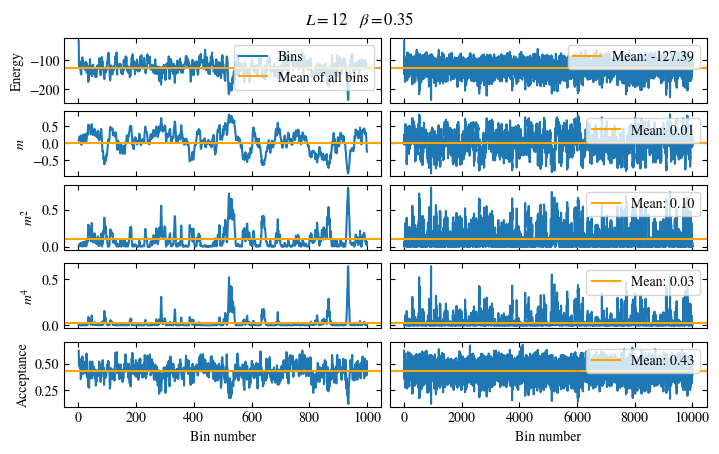

/tmp/ipykernel_67549/2254331124.py:43: RuntimeWarning: overflow encountered in exp
  return np.exp(-a*x)


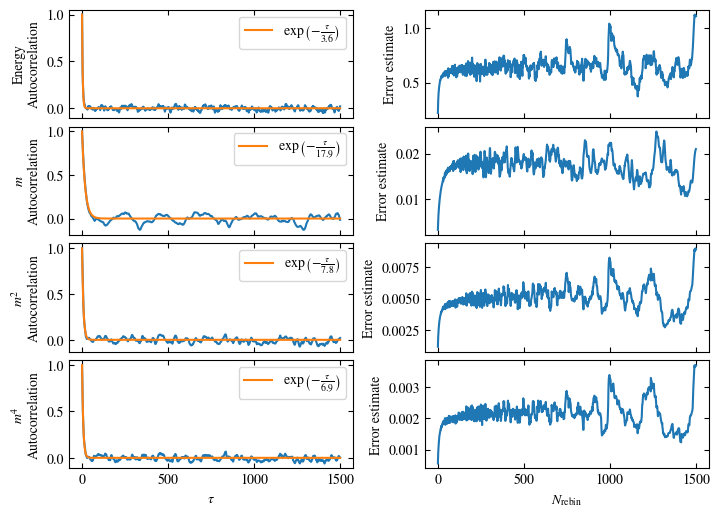

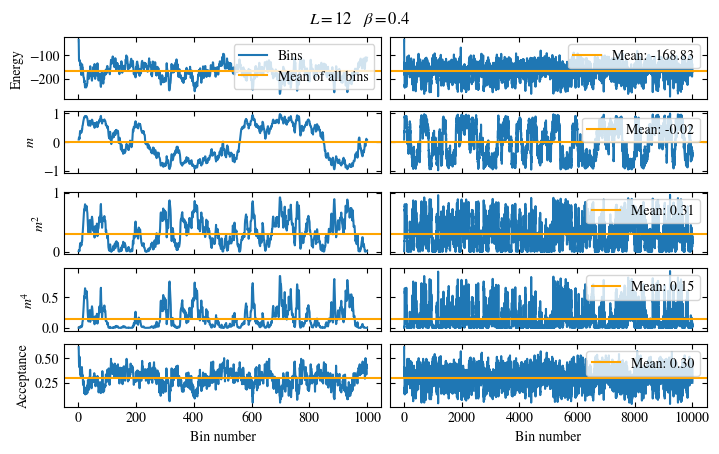

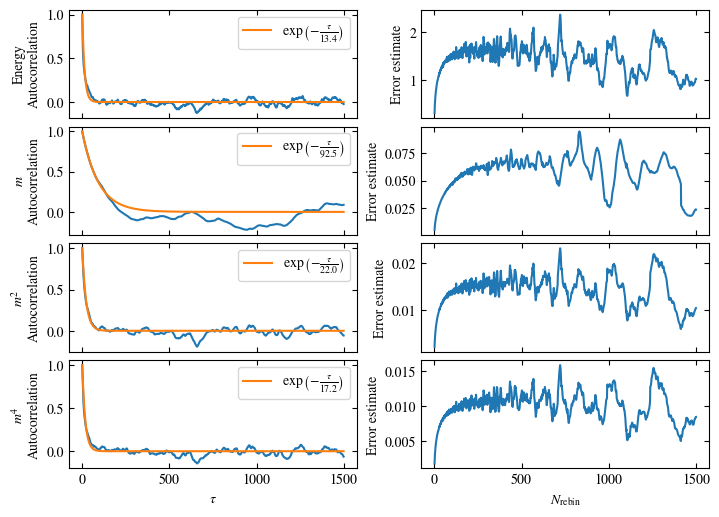

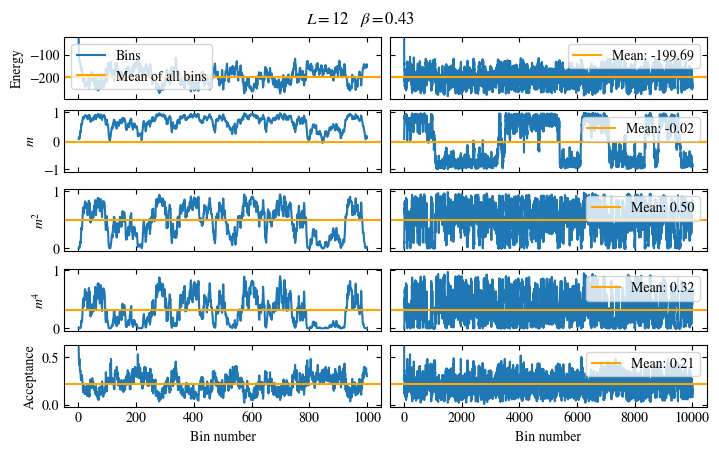

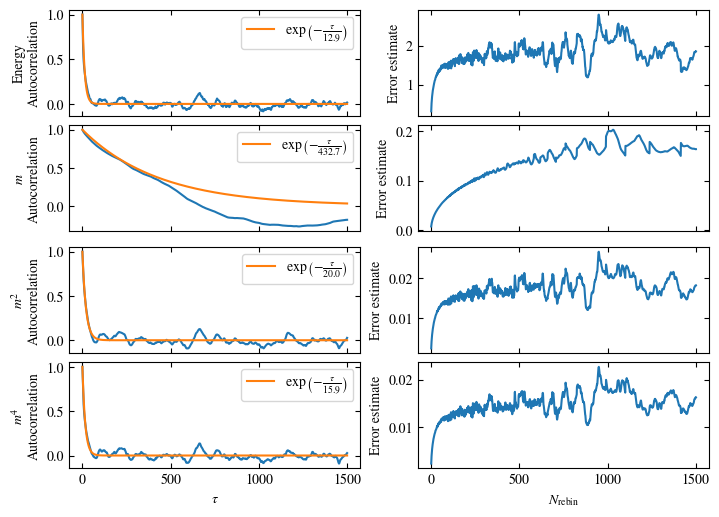

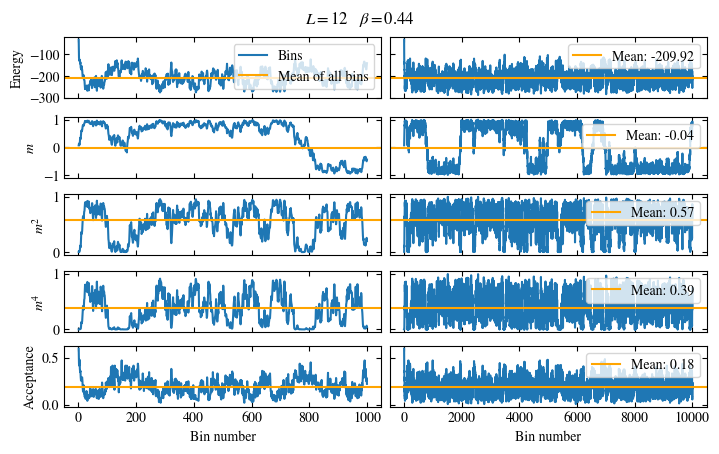

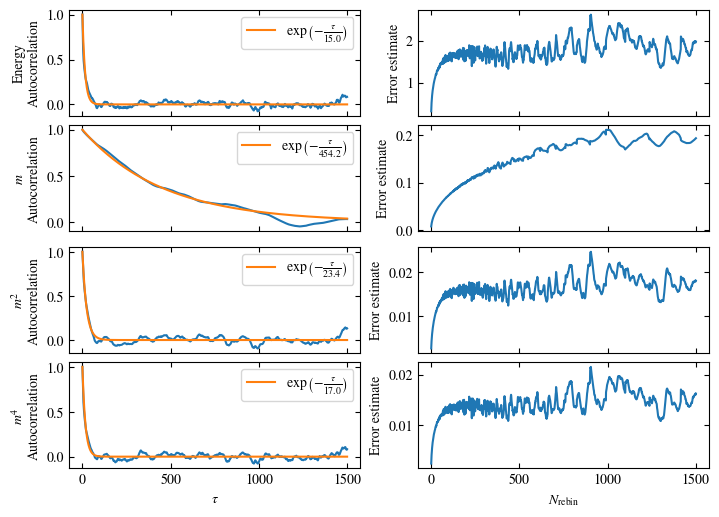

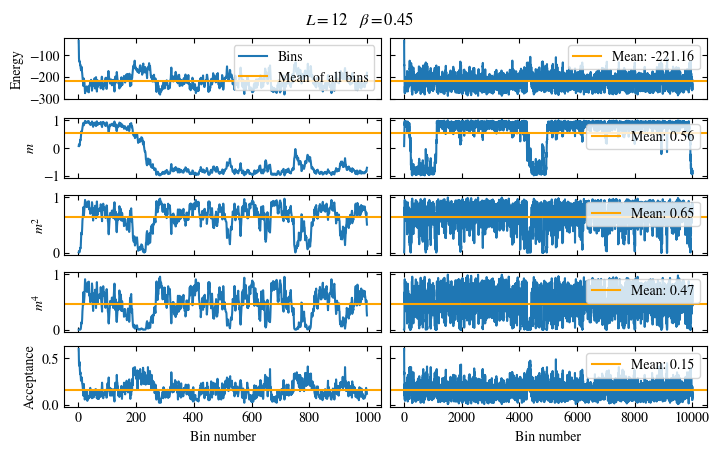

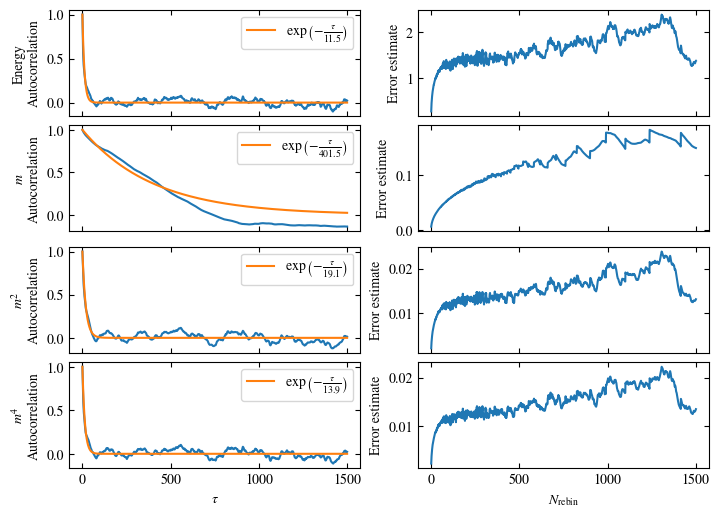

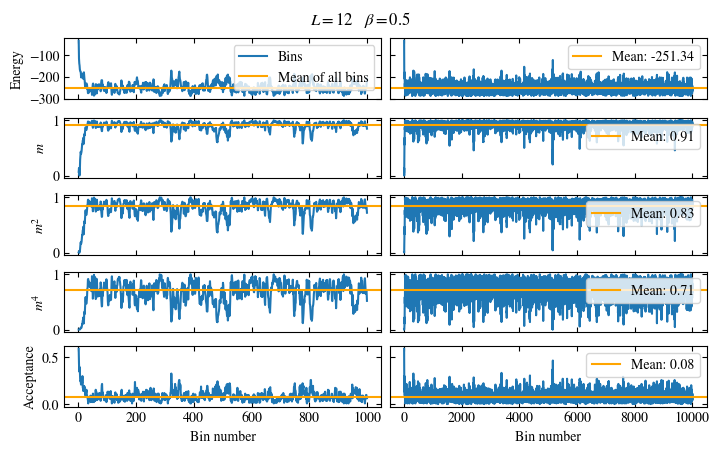

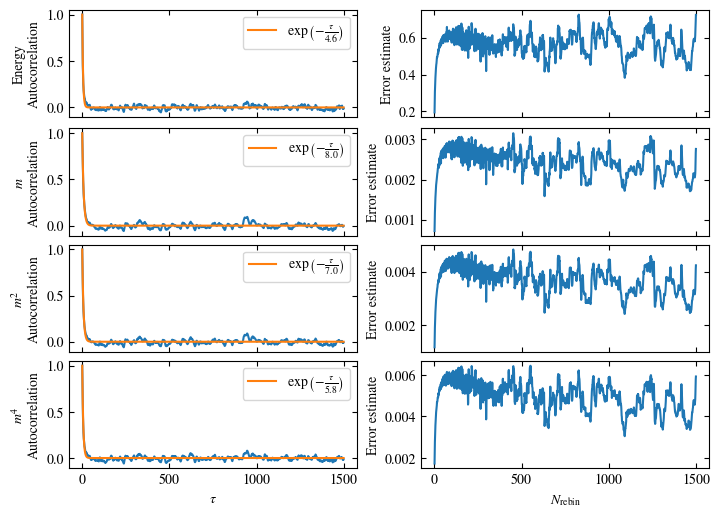

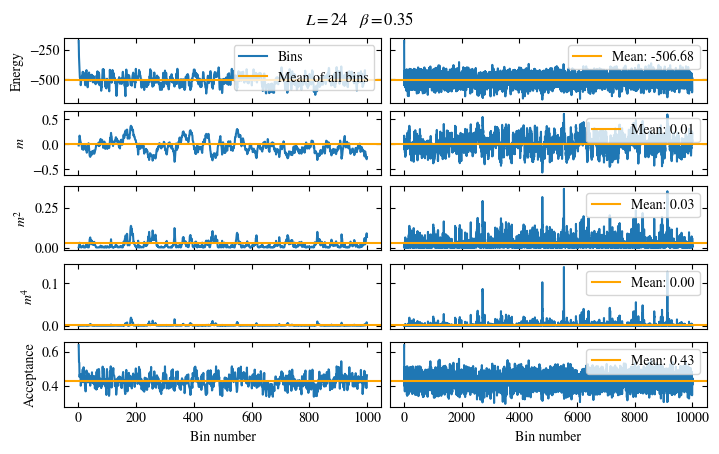

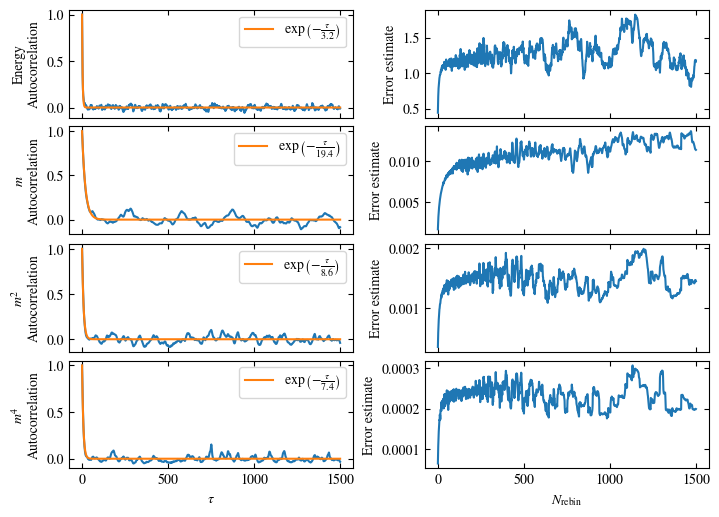

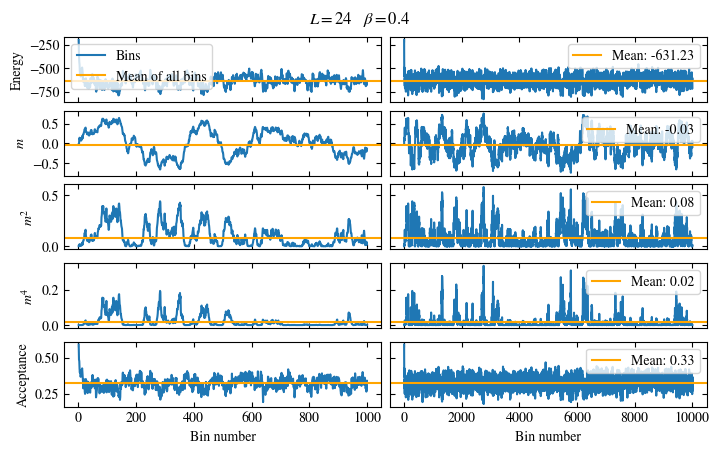

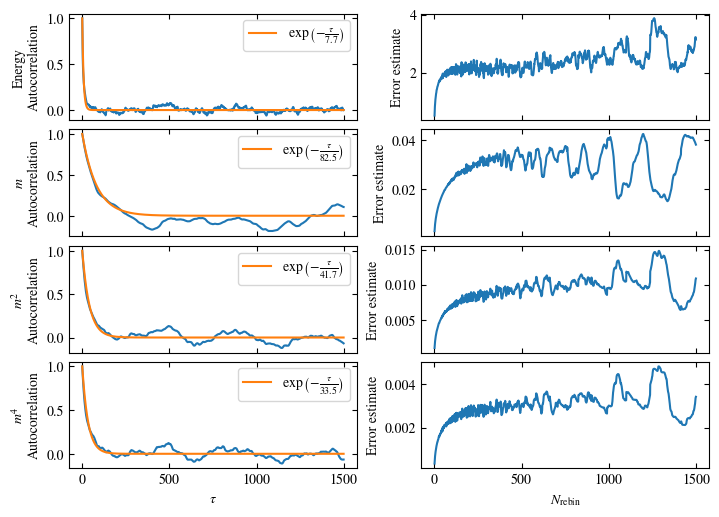

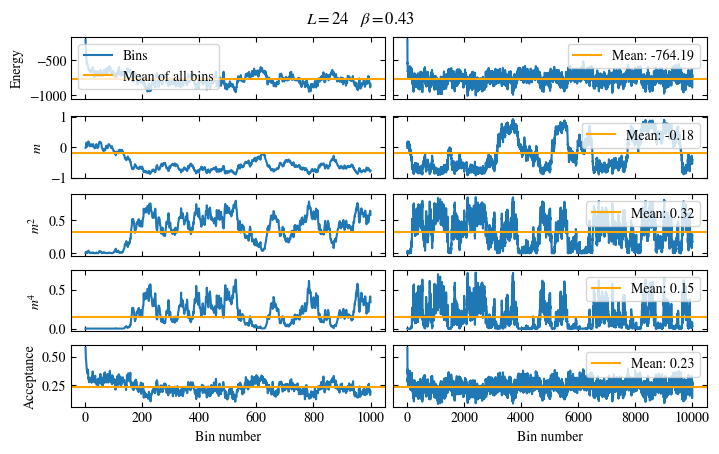

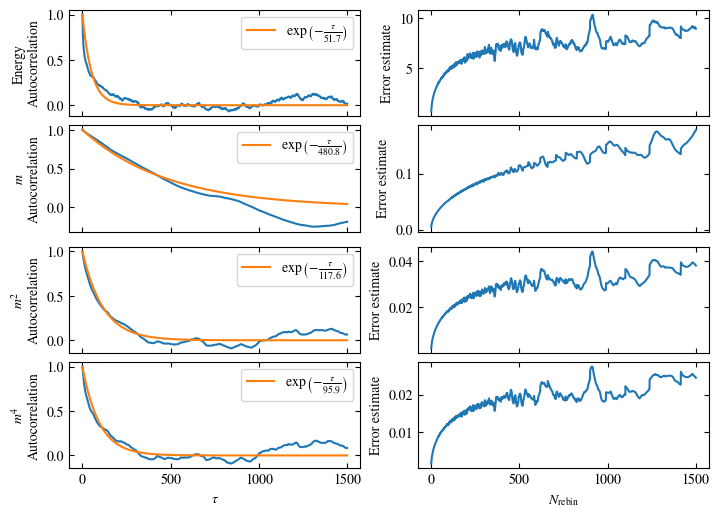

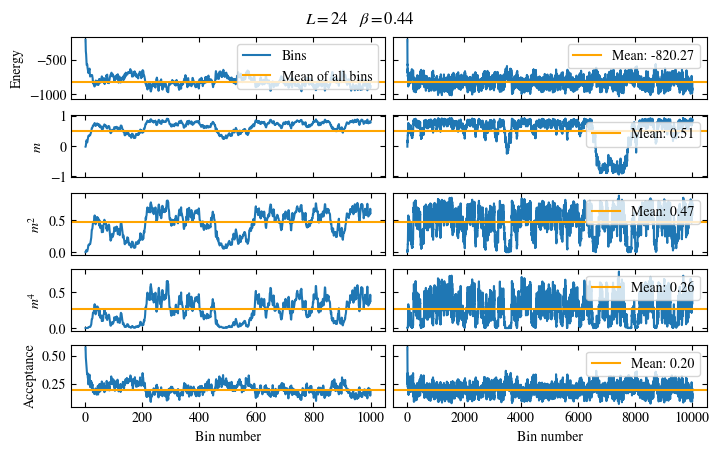

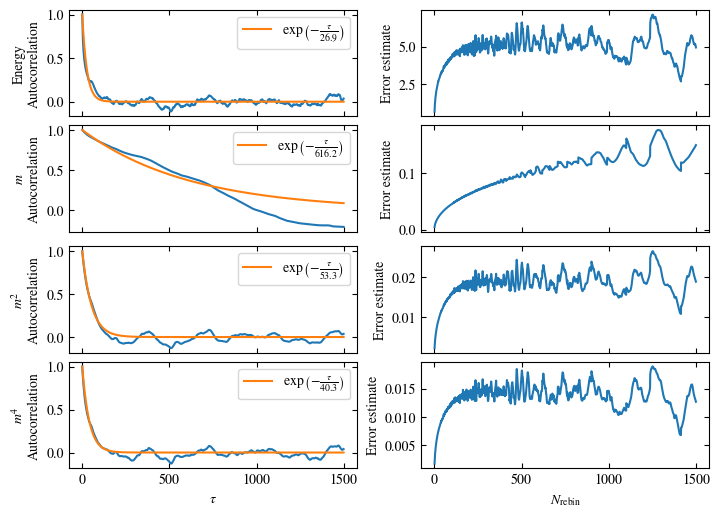

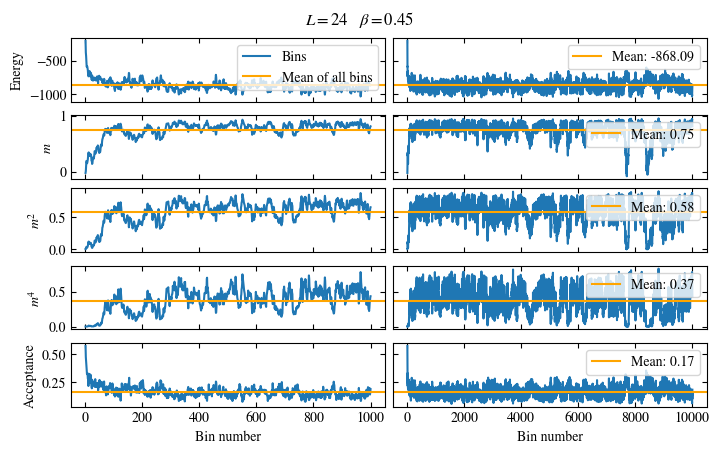

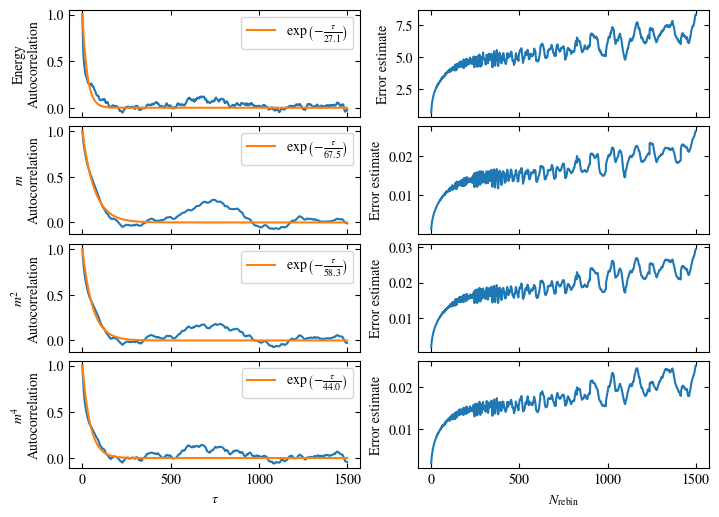

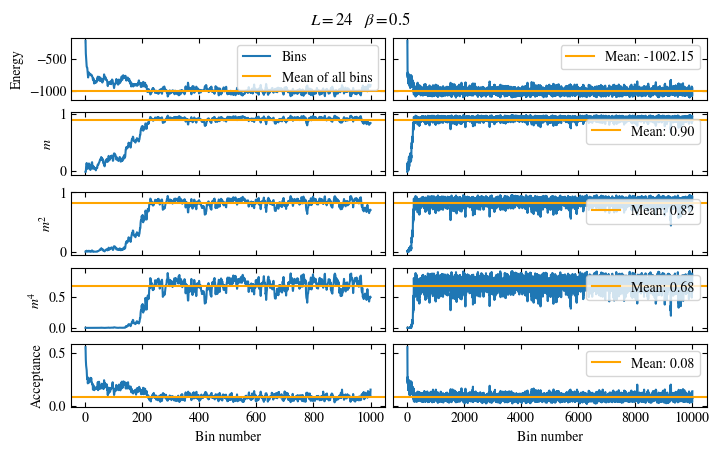

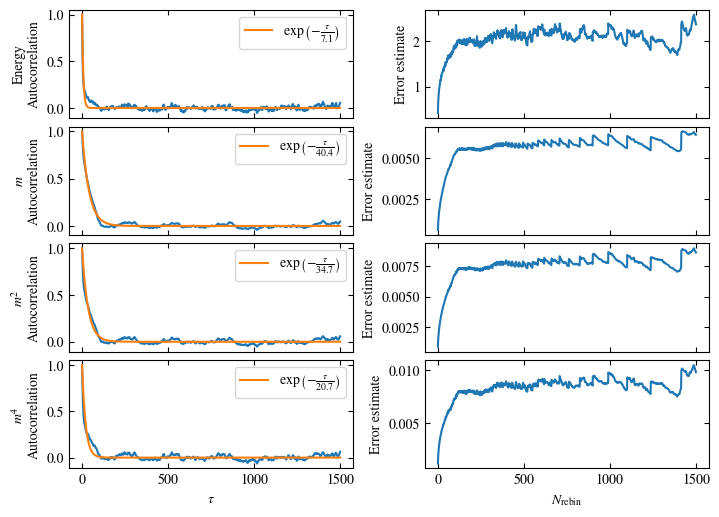

Time needed: 64.0563021779999s


In [13]:
# Simulate 2d Ising model for different L and beta.

import timeit
import pandas as pd

def binder(m_2, m_4):
    return (3 - m_4 / m_2**2)/2

def binder_err(m_2, m_4, m_2_err, m_4_err):
    return np.sqrt((m_2_err * m_4 / m_2**3)**2 
                   + (m_4_err / m_2**2 / 2)**2)

N_bins = 10000  # Number of Monte Carlo bins
J = 1

parameters = []
for L in [12, 24]:
    for beta in [0.35, 0.40, 0.43, 0.44, 0.45, 0.50]:
        parameters.append((L, beta))

results = []
time_start = timeit.default_timer()
for i, (L, beta) in enumerate(parameters):
    # Run Markov Chain Monte Carlo.
    observables, final_state = run_2d_ising_wrap(L, J, beta, N_bins)
    # Plot time series of bins to check warmup.
    plot_bins(observables, title=r'$L={}\quad\beta={}$'.format(L, beta))
    # Plot autocorrelation and error estimate to check autocorrelation time.
    plot_auto_err(observables, N_skip=100, N_rebin_max=1500)

    # Perform final error analysis
    N_skip = 300
    N_rebin = 500
    result = analyze(observables, N_skip, N_rebin)
    result['beta'] = beta
    result['L'] = L
    # Calculate Binder Cumulant out of m_2 and m_4.
    m_2_bins = rebin(observables['m_2']['bins'][N_skip:], N_rebin)
    m_4_bins = rebin(observables['m_4']['bins'][N_skip:], N_rebin)
    B_bins = binder(m_2_bins, m_4_bins)
    result['binder'] = np.mean(B_bins)
    result['binder_err'] = stderr(B_bins)
    results.append(result)
time_end = timeit.default_timer()
results = pd.DataFrame(results)
print(f'Time needed: {time_end-time_start}s')

In [14]:
results

energy  energy_err  energy_tau_auto         m     m_err  m_tau_auto  \
0   -127.472019    0.711783         3.646199  0.004689  0.018667   17.882681   
1   -168.993253    1.652951        13.364720 -0.025373  0.066010   92.541436   
2   -199.897099    1.848749        12.902298 -0.040255  0.135335  432.653396   
3   -210.313385    1.456617        14.951337 -0.060021  0.152532  454.177801   
4   -221.459891    1.391477        11.477330  0.563715  0.117968  401.467301   
5   -251.512629    0.546523         4.627051  0.911170  0.002555    8.009501   
6   -506.730442    1.256998         3.166393  0.009333  0.011569   19.403720   
7   -630.793436    2.280560         7.680795 -0.031983  0.030315   82.537656   
8   -765.251372    7.455663        51.681970 -0.171308  0.107974  480.795424   
9   -821.468668    4.592118        26.851391  0.506454  0.096907  616.191522   
10  -869.632283    5.435603        27.131311  0.752887  0.016644   67.521716   
11 -1005.789875    1.096175         7.072537  0.912085  0.001158   40.443066   

         m_2   m_2_err  m_2_tau_auto       m_4   m_4_err  m_4_tau_auto  \
0   0.104323  0.005425      7.808742  0.026598  0.002259      6.889143   
1   0.306493  0.016624     21.955901  0.150630  0.011549     17.204389   
2   0.502812  0.018066     20.045506  0.318673  0.015087     15.887557   
3   0.574935  0.013793     23.390160  0.392719  0.011620     17.019183   
4   0.653022  0.013314     19.123566  0.473975  0.012502     13.878272   
5   0.835700  0.003832      6.982193  0.713092  0.005031      5.820425   
6   0.026694  0.001897      8.608649  0.002035  0.000291      7.354062   
7   0.080554  0.009579     41.724180  0.015968  0.003056     33.511404   
8   0.320899  0.030867    117.640326  0.150611  0.019932     95.901529   
9   0.471972  0.017001     53.264992  0.264850  0.012625     40.250192   
10  0.586570  0.019124     58.312216  0.374079  0.016874     43.955118   
11  0.833103  0.002061     34.667410  0.697905  0.003293     20.732567   

    acceptance  acceptance_err  beta   L    binder  binder_err  
0     0.426173        0.002014  0.35  12  0.289044    0.033778  
1     0.297676        0.004589  0.40  12  0.690784    0.030375  
2     0.211092        0.004769  0.43  12  0.862095    0.016815  
3     0.182924        0.003719  0.44  12  0.902908    0.011888  
4     0.153978        0.003496  0.45  12  0.944235    0.008760  
5     0.079334        0.001154  0.50  12  0.989430    0.001299  
6     0.429113        0.000956  0.35  24  0.192207    0.029193  
7     0.326803        0.001541  0.40  24  0.421718    0.036584  
8     0.232732        0.004765  0.43  24  0.733018    0.068020  
9     0.195215        0.002910  0.44  24  0.896981    0.019072  
10    0.164089        0.003396  0.45  24  0.953328    0.013974  
11    0.079085        0.000598  0.50  24  0.997267    0.000178

In [15]:
# Summarize the found autocorrelation times in one figure.
beta_c = np.log(1 + np.sqrt(2))/2
fig, axs = plt.subplots(5, 1, constrained_layout=True, figsize=(width, width))
fig.suptitle('Autocorrelation times')
for ax, name, label in zip(
        axs,
        ['energy_tau_auto', 'm_tau_auto', 'm_2_tau_auto', 'm_4_tau_auto', 'acceptance'],
        [r'$\tau_\text{auto}$ of Energy', r'$\tau_\text{auto}$ of $m$',
         r'$\tau_\text{auto}$ of $m^2$', r'$\tau_\text{auto}$ of $m^4$',
         r'Acceptance ratio'
        ],
    ):
    for L in pd.unique(results.L):
        df = results.query(f'L == {L}')
        ax.plot(df.beta, df[name], '-x', label=f'$L={L}$')
    ax.set_ylim(0, results[name].max()*1.1)
    ax.set_ylabel(label)
    ax.axvline(beta_c, color='tab:red', label=r'$\beta_c$')

axs[-1].set_xlabel(r'Reciprocal temperature $\beta$')
axs[1].legend(ncols=2)
fig.savefig('chap1_figures/2d-ising-tauauto.svg')
plt.close(fig)

```{figure} chap1_figures/2d-ising-tauauto.svg
---
name: fig:2d-ising-tauauto
---
Autocorrelation times and acceptance ratio for 2d Ising model for two lattice sizes, simulated using single spin flip updates. The autocorrelation times increase dramatically around the critical point $\beta_c$, a phenomenon that is called critical slowing down. The acceptance ratio is high in the disordered phase at high temperature and decreases when approaching the ordered phase by decreasing the temperature.
```

In [16]:
# Plot Binder ratio.
fig, ax = plt.subplots(
    1, 1,
    constrained_layout=True,
    figsize=(5, 3),
)
ax_inset = ax.inset_axes(
        [.45, .22, .05, .5],
        transform=ax.transData,
    )
ax.indicate_inset([.425, .64, .03, .35],
                  inset_ax=ax_inset)

for L in pd.unique(results.L):
    df = results.query(f'L == {L}')
    df2 = df.query('beta > 0.42 & beta < 0.46')
    ax.errorbar(df.beta, df.binder, df.binder_err, label=f'L={L}', capsize=3)
    ax_inset.errorbar(df2.beta, df2.binder, df2.binder_err, capsize=3)

ax.set_ylabel('Binder ratio $B$')
ax.set_xlabel(r'$\beta$')
ax.axvline(beta_c, .57, 0.94, color='tab:red', label=r'$\beta_c$')
ax_inset.axvline(beta_c, color='tab:red', label=r'$\beta_c$')
    
ax.legend()
fig.savefig('chap1_figures/2d-ising-binder.svg')
plt.close(fig)

```{figure} chap1_figures/2d-ising-binder.svg
---
name: fig:2d-ising-binder
---
Binder ratio for 2d Ising model at $J=1$. The crossing around $\beta \approx 0.44$ signals a phase transition, a result which is in accordance with the exact result by Onsager from 1944&nbsp;{cite}`Onsager44`.
```

#### Solving critical slowing down with the Wolff algorithm

A strategy for addressing critical slowing down, or ergodicity challenges in general, is to go from atomistic (e.g. single spin flip) updates to bigger correlated updates, which for example flip an entire cluster of spins.
Updates like these are generally very hard to design: Most states in the phase space have high energy, therefore a random configuration change $C \rightarrow C'$ is very likely to increase the energy, moving the system away from the higher-weighted low-energy states.
The positive energy mismatch $E(C') - E(C)$ reduces the weight &mdash;and therefore the acceptance probability of that state&mdash; exponentially (cf. Eq.&nbsp;{eq}`eq:Metropolis-Hastings-acceptance`). Or in other words: Proposing an update that moves the configuration fast through the configuration space, will most likely result in a very low acceptance probability, except if significant knowledge about the model was used to design the update.

An example of a well-designed algorithm generating such updates is the Wolff algorithm&nbsp;{cite}`Wolff-89`. It is specifically designed for simulating the Ising model, by building clusters of spins that get flipped collectively. Notably, each cluster is built in such a way that $\frac{W(C') g(C | C')}{W(C) g(C' | C)} = 1$ (cf. Eq.&nbsp;{eq}`eq:Metropolis-Hastings-acceptance`), hence flipping a cluster is accepted with probability $1$.

````{prf:algorithm} Wolff cluster
:label: wolff-cluster

1. **Choose initial spin:** Randomly chose one spin as the seed for the cluster.
2. **Try to add neighboring spins:** For all neighboring spins that are not already part of the cluster and have the same orientation as the spins in the cluster: Try to add this spin to the cluster with probability $1 - \exp(-2\beta J)$.
3. If a spin gets added, perform step 2 for that spin.
4. Flip cluster.
````

Simulating the two-dimensional Ising model with the help of {prf:ref}`wolff-cluster` leads to autocorrelation times and average cluster sizes as displayed in {numref}`fig:2d-ising-wolff-tauauto`.
The algorithm solves critical slowing down by scaling the average cluster size with the correlation length in the system. 
With this approach, we manage to create more precise data in less time.[^times_single_vs_wolff]
The result is displayed in {numref}`fig:2d-ising-wolff-binder`.

[^times_single_vs_wolff]: In this concrete example, the simulations for {numref}`fig:2d-ising-binder` took my computer about 64 seconds to complete, while the simulations for {numref}`fig:2d-ising-wolff-binder` took about 21 seconds, even though the former only computed system sizes $12 \times 12$ and $24 \times 24$, while the latter went up to sizes of $36 \times 36$.

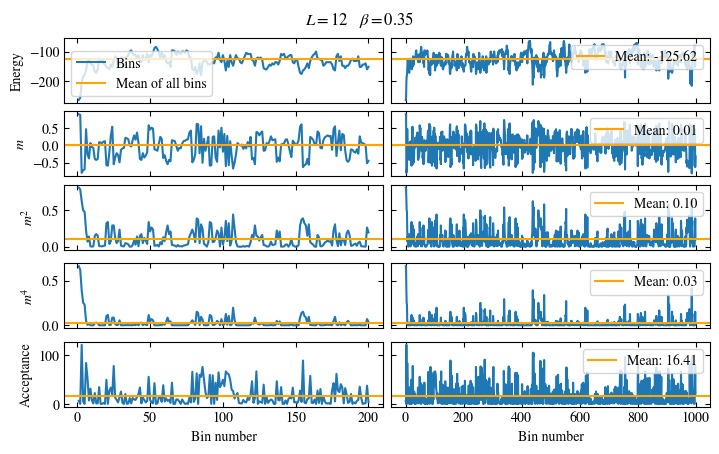

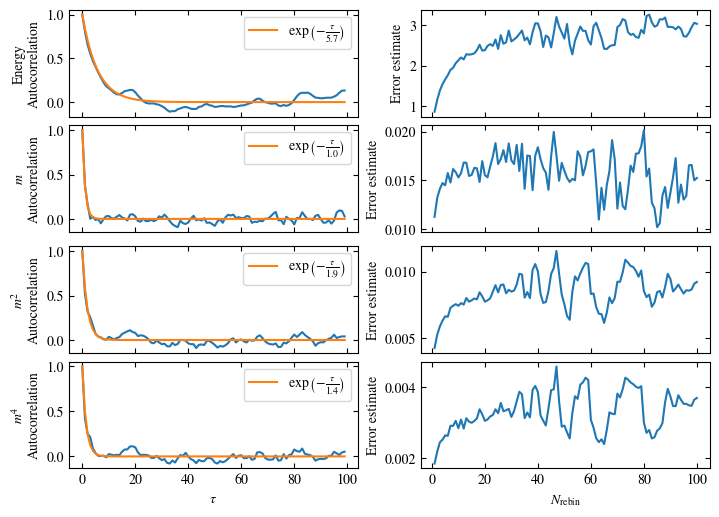

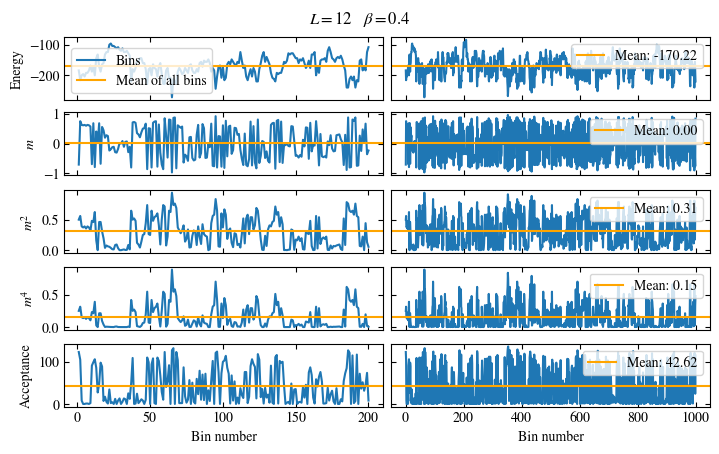

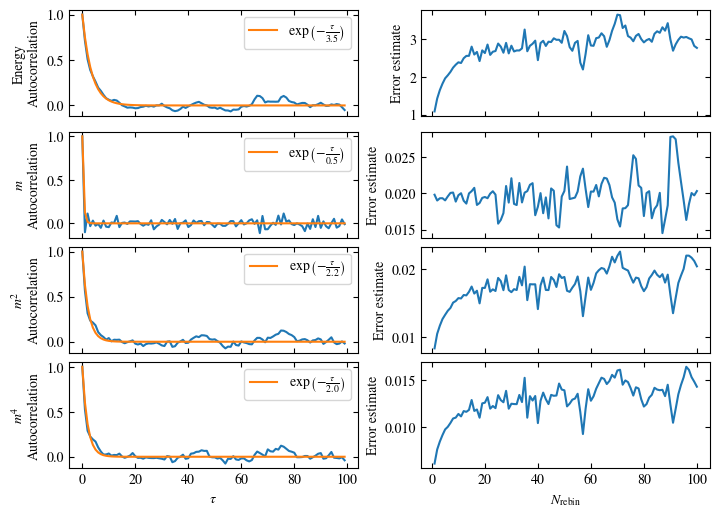

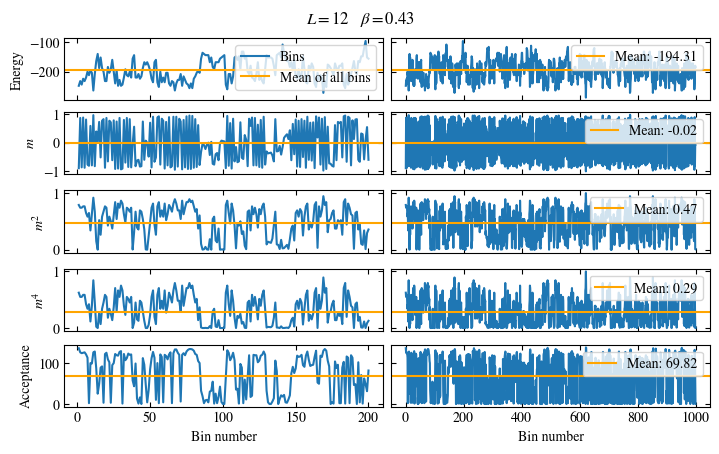

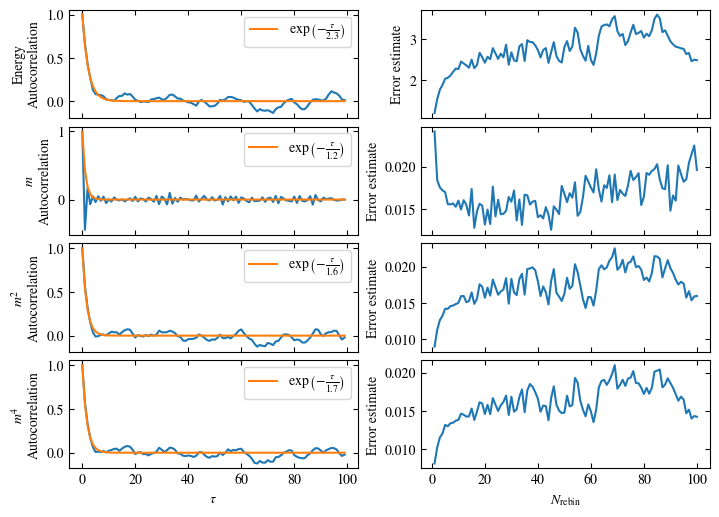

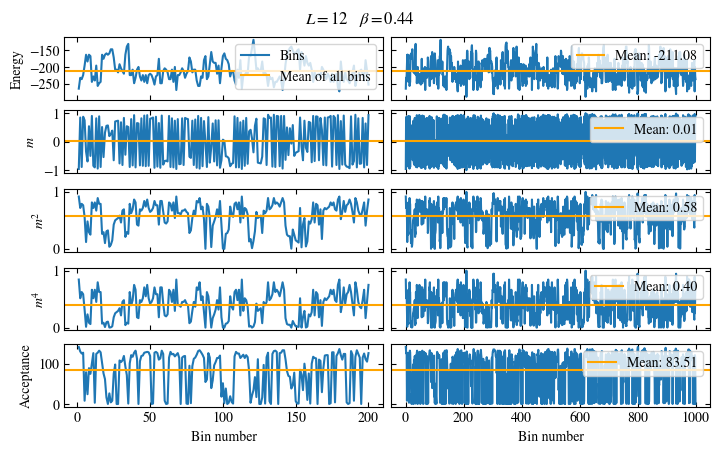

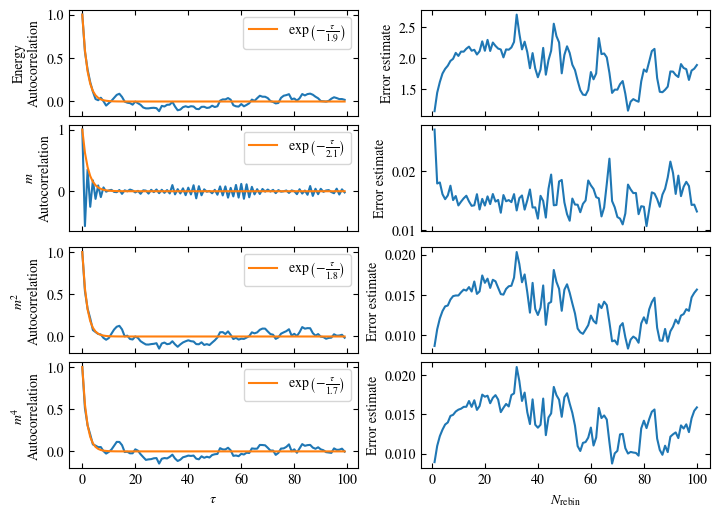

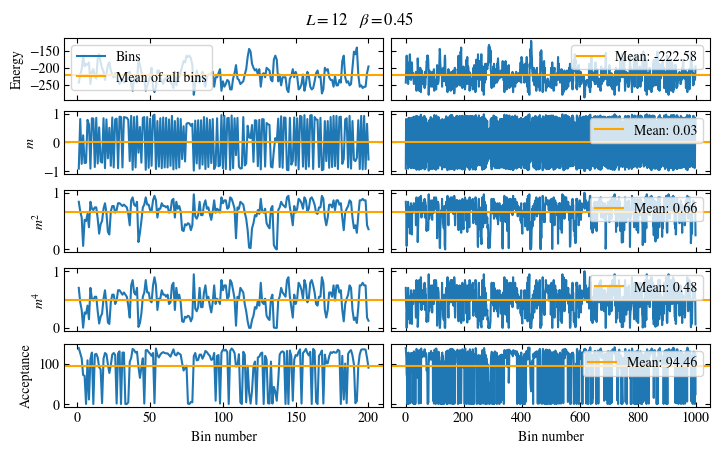

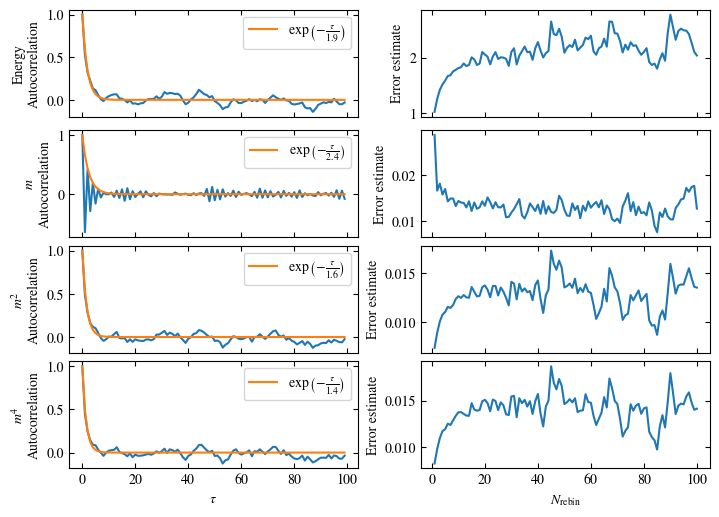

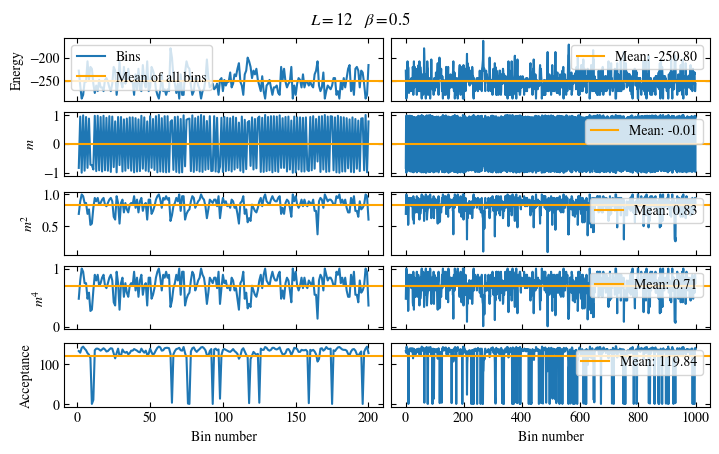

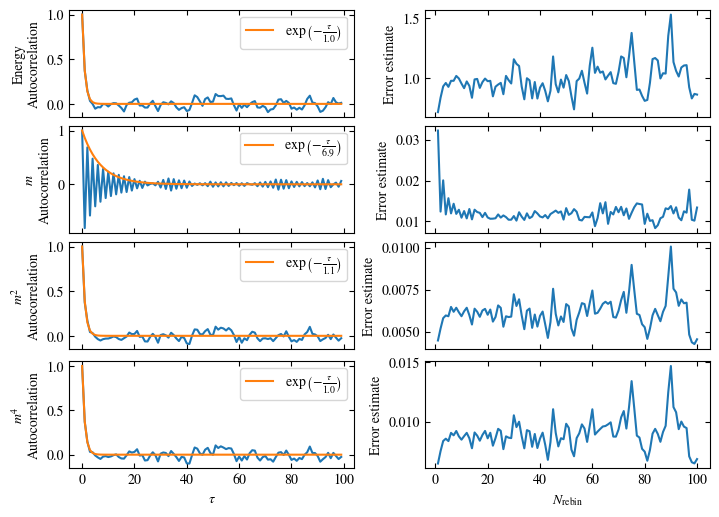

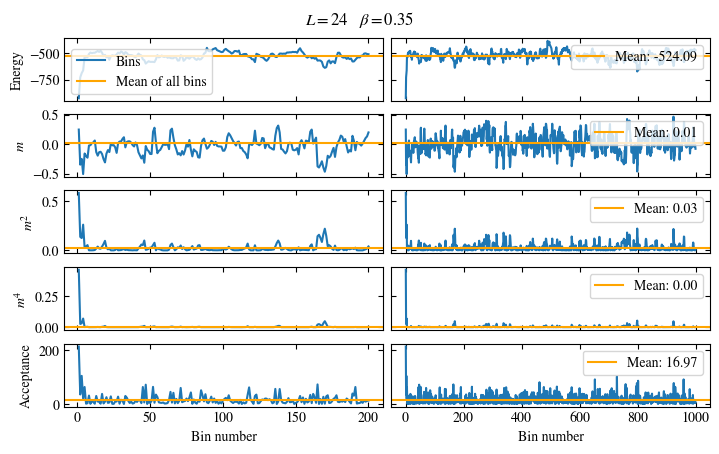

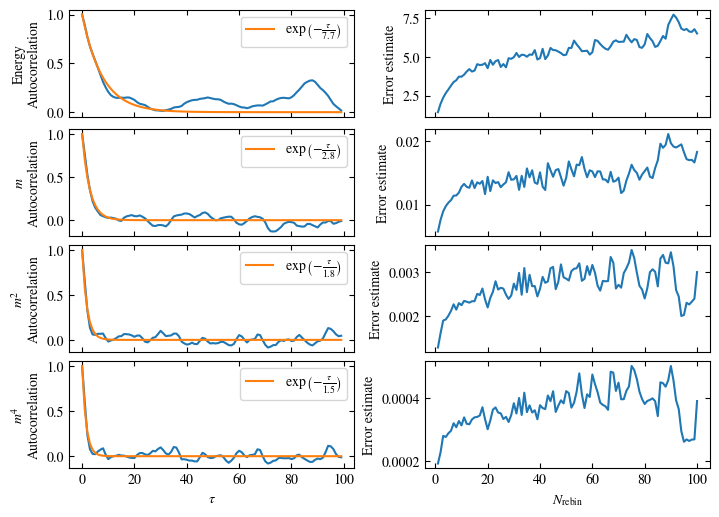

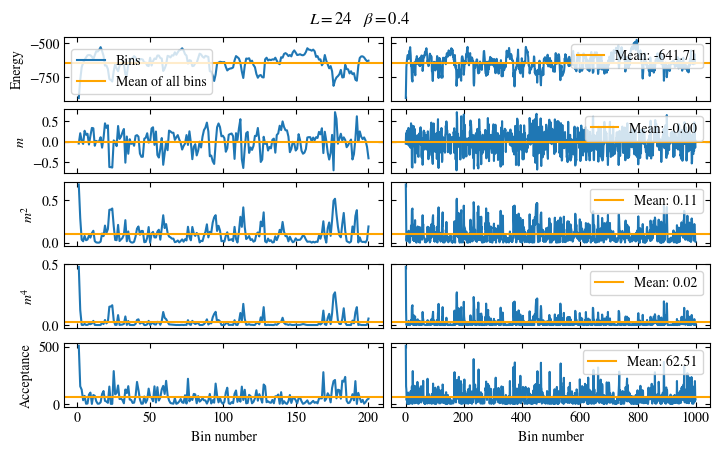

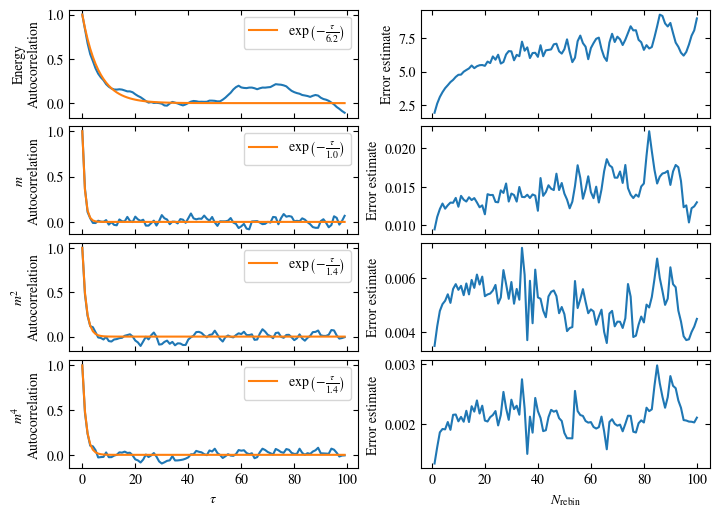

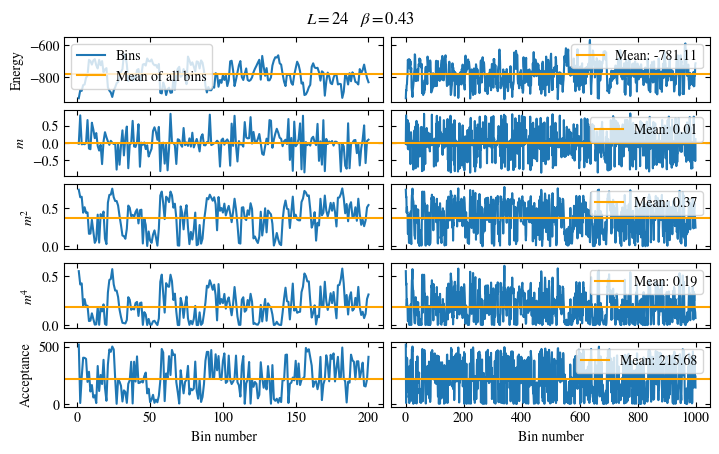

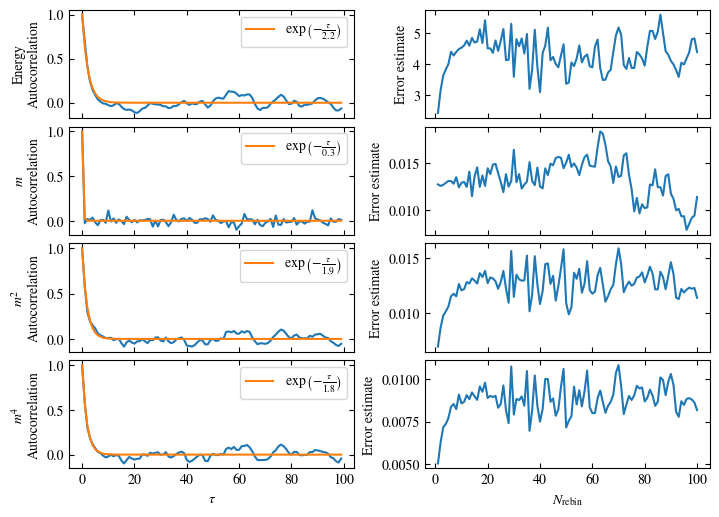

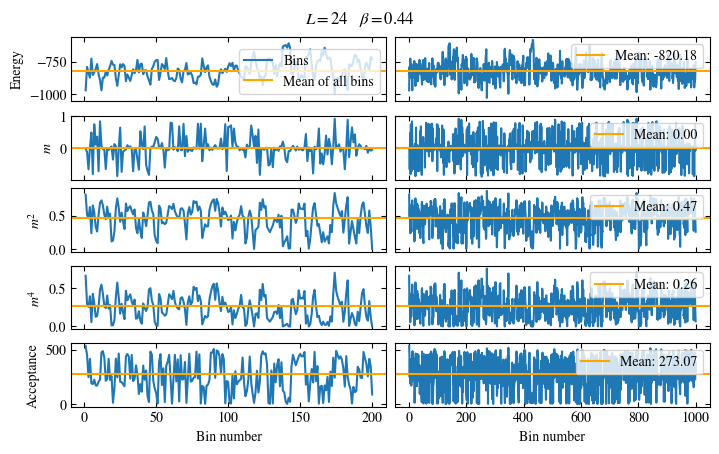

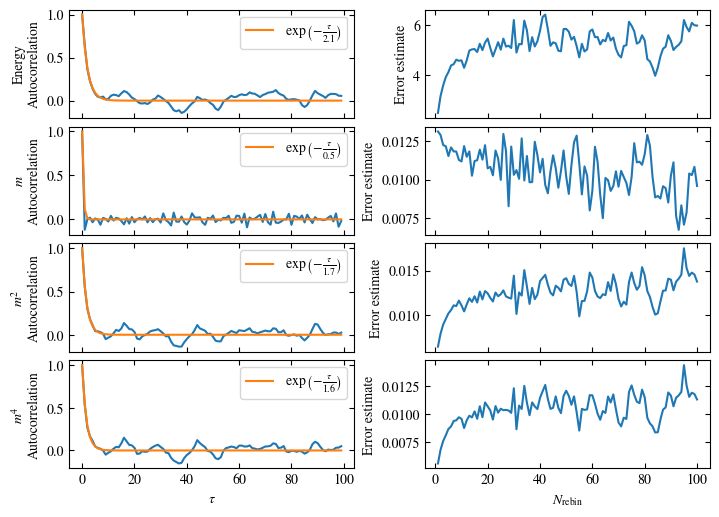

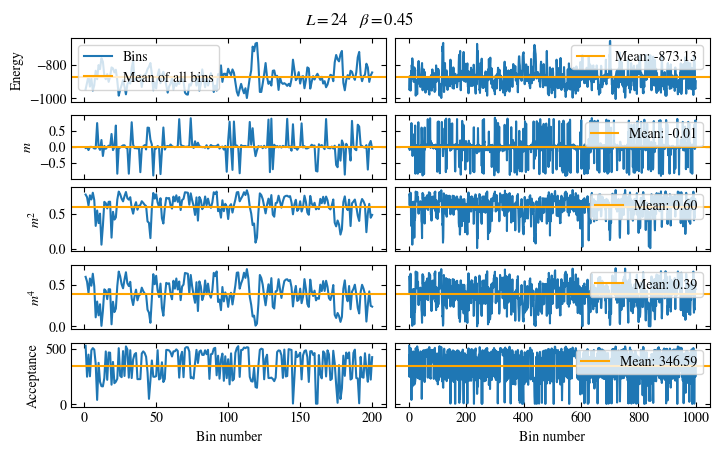

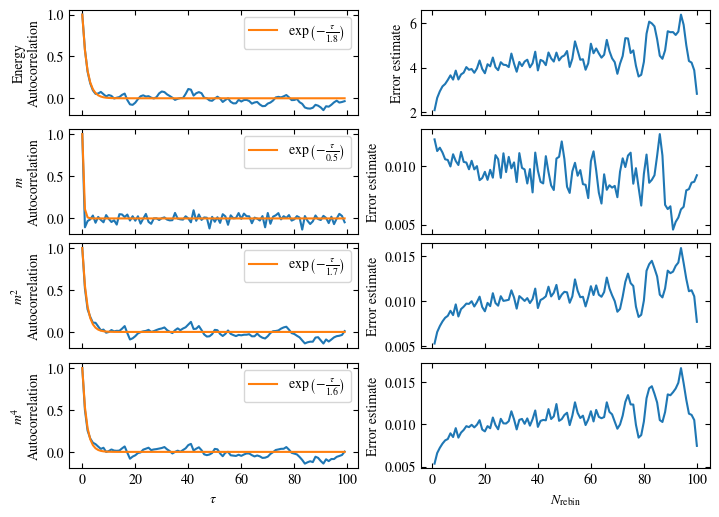

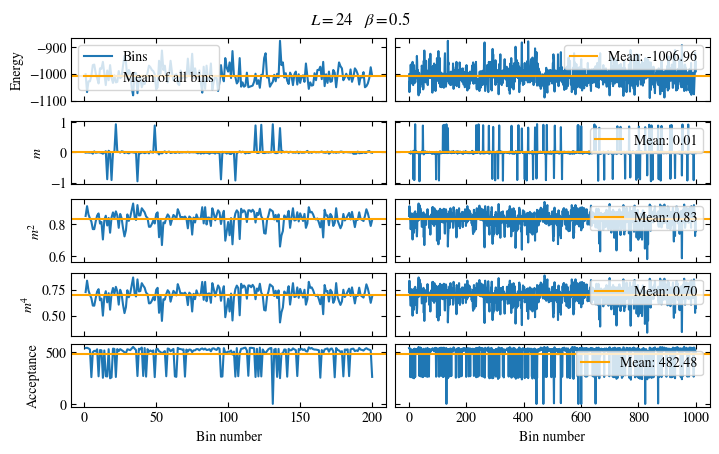

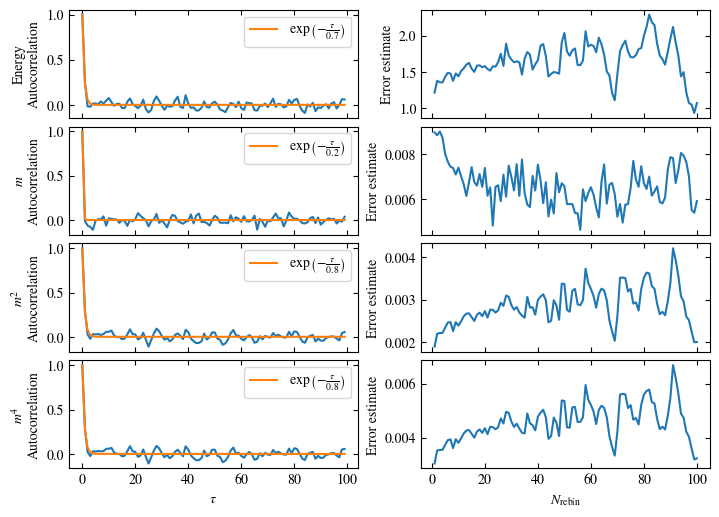

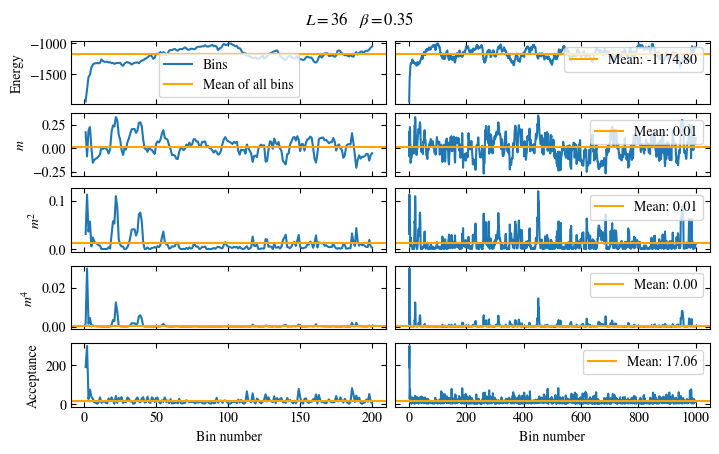

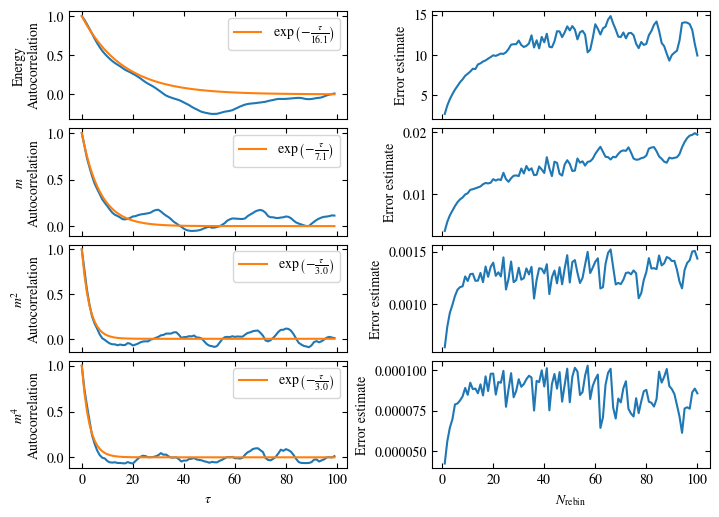

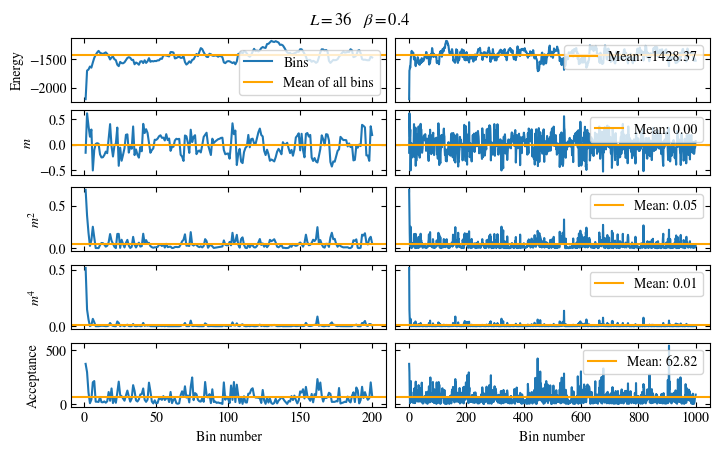

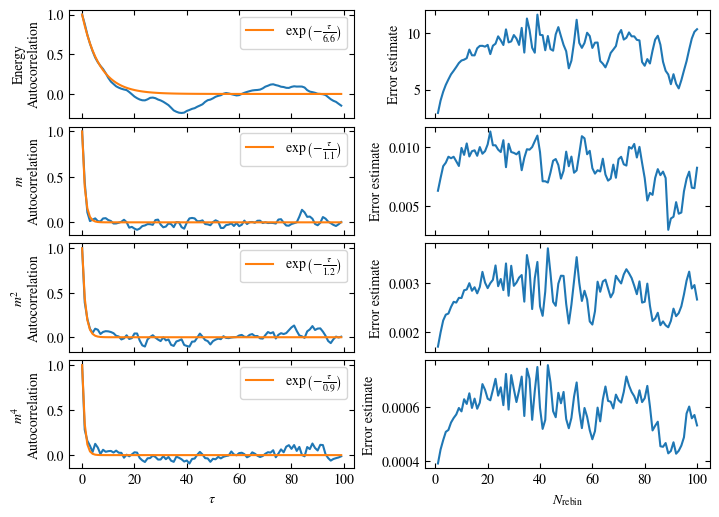

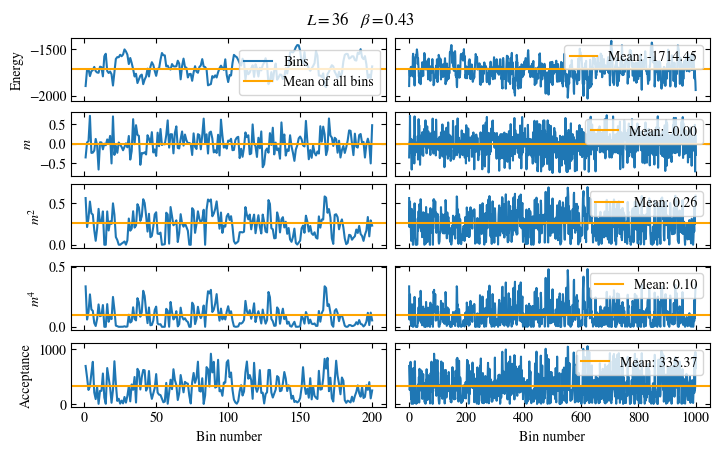

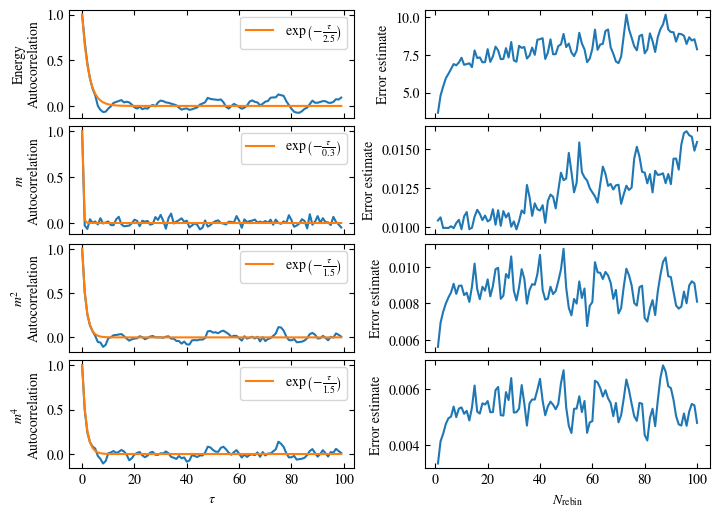

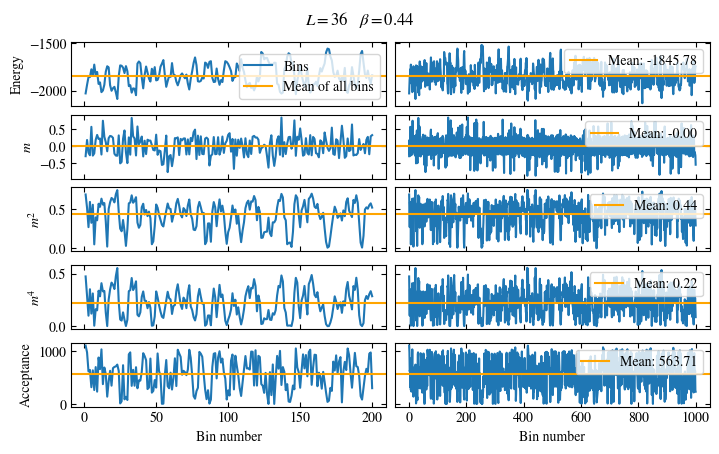

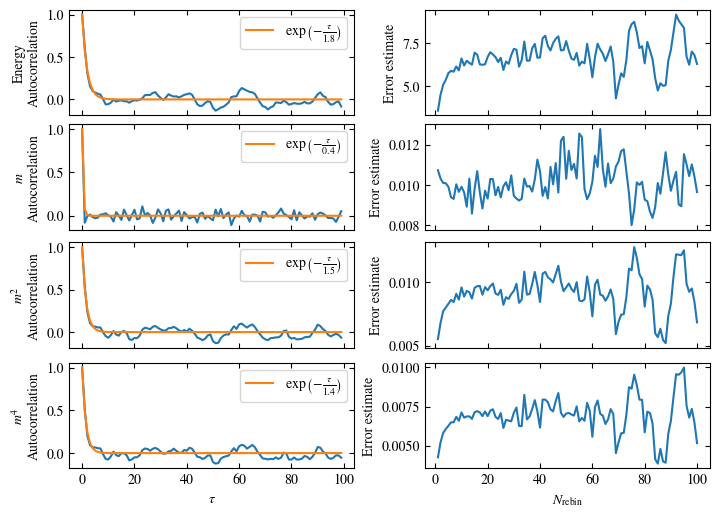

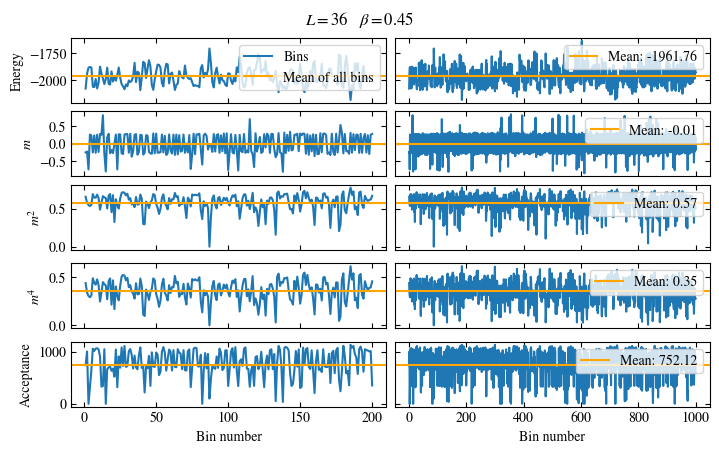

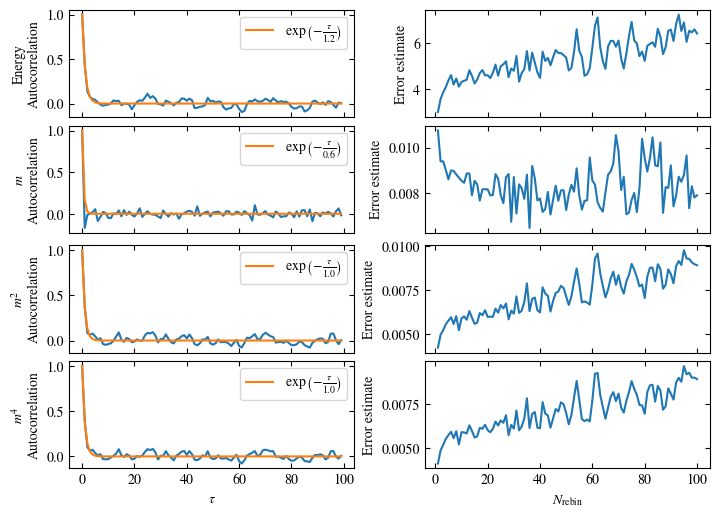

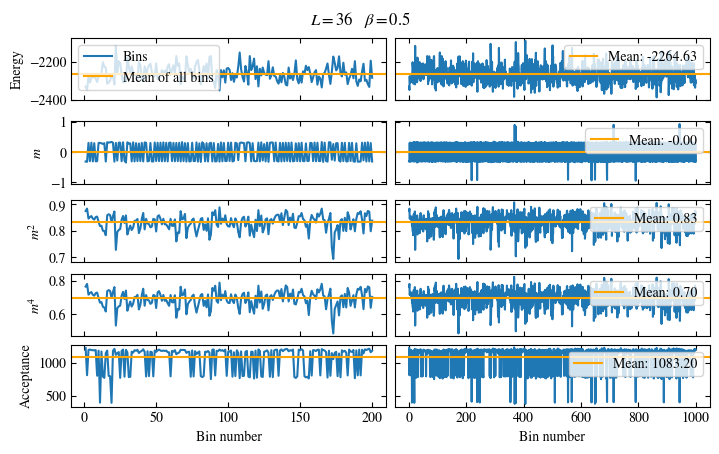

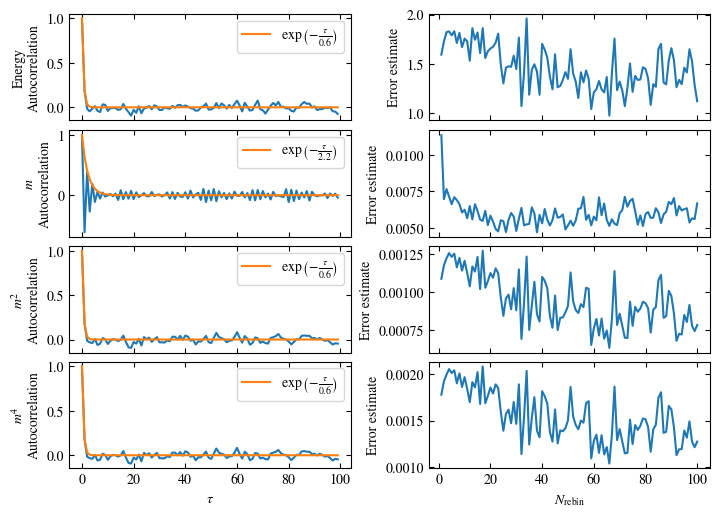

Time needed: 20.825602831999277s


In [17]:
# Simulate 2d Ising model again, but this time with Wolff cluster updates.

def binder(m_2, m_4):
    return (3 - m_4 / m_2**2)/2

def binder_err(m_2, m_4, m_2_err, m_4_err):
    return np.sqrt((m_2_err * m_4 / m_2**3)**2 
                   + (m_4_err / m_2**2 / 2)**2)

J = 1.0        # Ferromagnetic interaction strength
N_bins = 1000  # Number of Monte Carlo bins

parameters = []
#for L in [12, 24, 36]:
for L in [12, 24, 36]:
    #for beta in np.linspace(.4, .47, 8):
    #for beta in [0.435, 0.44, 0.445, 0.45]:
    for beta in [0.35, 0.40, 0.43, 0.44, 0.45, 0.50]:
    #for beta in [0.40, 0.50, 0.60, 1., 2., 3., 4., 5., 6.]:
        parameters.append((L, beta))

results = []
time_start = timeit.default_timer()
for i, (L, beta) in enumerate(parameters):
    observables, final_state = run_2d_ising_wrap(
        L, J, beta, N_bins,
        #update_scheme='single-spin',
        update_scheme='wolff',
        random_seed=i,
        N_updates_per_bin=L//12,
        initial_state=np.array(np.ones((L, L)), dtype=float)
    )
    plot_bins(observables, zoom_windom=200, title=r'$L={}\quad\beta={}$'.format(L, beta))
    plot_auto_err(observables, N_skip=200, N_rebin_max=100)

    N_skip = 200
    N_rebin = 50 
    result = analyze(observables, N_skip, N_rebin)
    result['beta'] = beta
    result['L'] = L
    m_2_bins = rebin(observables['m_2']['bins'][N_skip:], N_rebin)
    m_4_bins = rebin(observables['m_4']['bins'][N_skip:], N_rebin)
    B_bins = binder(m_2_bins, m_4_bins)
    result['binder'] = np.mean(B_bins)
    result['binder_err'] = stderr(B_bins)
    result['binder_err2'] = binder_err(
        result['m_2'], result['m_4'],
        result['m_2_err'], result['m_4_err'])
    
    results.append(result)
time_end = timeit.default_timer()
print(f'Time needed: {time_end-time_start}s')

In [18]:
results = pd.DataFrame(results)
results

energy  energy_err  energy_tau_auto         m     m_err  m_tau_auto  \
0   -123.770000    2.668611         5.739185  0.014444  0.015993    1.024703   
1   -170.405000    3.217672         3.483819 -0.005295  0.020311    0.488656   
2   -193.750000    2.810512         2.285727 -0.017865  0.016815    1.194785   
3   -211.255000    2.053507         1.888565  0.007899  0.014736    2.138874   
4   -222.405000    2.088999         1.857874  0.025799  0.012466    2.412297   
5   -250.500000    1.027009         1.017029 -0.011667  0.013259    6.905287   
6   -522.400000    5.139859         7.676394  0.027925  0.014202    2.848737   
7   -642.052500    6.670073         6.156248 -0.003220  0.014105    0.965476   
8   -779.567500    3.363376         2.220128  0.009855  0.015082    0.280263   
9   -822.450000    5.840249         2.078990 -0.000655  0.010212    0.464586   
10  -872.092500    4.543141         1.801883 -0.013485  0.010588    0.453284   
11 -1006.872500    2.037519         0.692447  0.005360  0.006572    0.226039   
12 -1169.601667   13.034776        16.085296  0.005779  0.014883    7.100867   
13 -1424.741667    8.378905         6.642153  0.002425  0.009628    1.065044   
14 -1719.375000    8.027574         2.482047 -0.002970  0.013102    0.293001   
15 -1848.520000    7.616964         1.827118 -0.005331  0.010306    0.396356   
16 -1960.008333    5.367927         1.154340  0.000235  0.007260    0.555918   
17 -2265.675000    1.348143         0.593512 -0.003717  0.005161    2.240177   

         m_2   m_2_err  m_2_tau_auto       m_4   m_4_err  m_4_tau_auto  \
0   0.101535  0.007552      1.876882  0.024885  0.002916      1.448651   
1   0.313207  0.018880      2.156995  0.153236  0.013939      1.975337   
2   0.466848  0.016279      1.634623  0.282933  0.014800      1.698231   
3   0.585430  0.015643      1.760958  0.402641  0.017147      1.703177   
4   0.662409  0.013534      1.610291  0.482219  0.014628      1.429891   
5   0.828492  0.006638      1.054598  0.702381  0.009820      1.014284   
6   0.029665  0.002852      1.834682  0.002424  0.000421      1.516664   
7   0.106450  0.004661      1.422023  0.023985  0.001849      1.399516   
8   0.369367  0.010881      1.879570  0.182386  0.007156      1.788665   
9   0.477067  0.014138      1.728977  0.267762  0.012077      1.628697   
10  0.593869  0.011041      1.670373  0.381289  0.011099      1.587405   
11  0.832510  0.003363      0.770861  0.697175  0.005356      0.761044   
12  0.013680  0.001208      3.041543  0.000501  0.000080      2.950595   
13  0.043441  0.002575      1.216981  0.005255  0.000556      0.940092   
14  0.267553  0.008862      1.508539  0.105849  0.005340      1.490430   
15  0.439365  0.009604      1.503809  0.225860  0.007055      1.406312   
16  0.570570  0.007127      0.985122  0.346593  0.006998      1.034318   
17  0.833430  0.000910      0.578082  0.696454  0.001505      0.579916   

     acceptance  acceptance_err  beta   L    binder  binder_err  binder_err2  
0     15.921250        1.034336  0.35  12  0.309275    0.059599     0.228538  
1     42.883750        2.478172  0.40  12  0.715836    0.029908     0.117958  
2     68.358750        2.747791  0.43  12  0.850464    0.015041     0.056587  
3     83.957500        2.184081  0.44  12  0.913780    0.008088     0.040140  
4     94.786250        2.489764  0.45  12  0.950388    0.006473     0.027965  
5    118.651250        1.273549  0.50  12  0.988599    0.001407     0.010881  
6     16.906250        0.538736  0.35  24  0.157513    0.079215     0.357037  
7     63.063750        3.194459  0.40  24  0.455264    0.032675     0.123472  
8    211.825625        6.271818  0.43  24  0.827661    0.016359     0.047314  
9    276.008125        8.404162  0.44  24  0.911419    0.011016     0.043813  
10   344.945000        8.009861  0.45  24  0.959757    0.005002     0.025526  
11   483.018750        2.489783  0.50  24  0.997138    0.000240     0.005607  
12    16.394583        0.490239  0.35  36  0.226306   

In [19]:
# Summarize the found autocorrelation times in one figure.
beta_c = np.log(1 + np.sqrt(2))/2
fig, axs = plt.subplots(5, 1, constrained_layout=True, figsize=(width, width))
fig.suptitle('Autocorrelation times')
for ax, name, label in zip(
        axs,
        ['energy_tau_auto', 'm_tau_auto', 'm_2_tau_auto', 'm_4_tau_auto', 'acceptance'],
        [r'$\tau_\text{auto}$ of Energy', r'$\tau_\text{auto}$ of $m$',
         r'$\tau_\text{auto}$ of $m^2$', r'$\tau_\text{auto}$ of $m^4$',
         r'Average cluster size $/L^2$'
        ],
    ):
    for L in pd.unique(results.L):
        df = results.query(f'L == {L}')
        ax.plot(df.beta, df[name], '-x', label=f'$L={L}$')
    ax.set_ylim(0, results[name].max()*1.1)
    ax.set_ylabel(label)
    ax.axvline(beta_c, color='tab:red', label=r'$\beta_c$')

axs[-1].set_xlabel(r'Reciprocal temperature $\beta$')
axs[-1].legend(ncols=2)
fig.savefig('chap1_figures/2d-ising-wolff-tauauto.svg')
plt.close(fig)

```{figure} chap1_figures/2d-ising-wolff-tauauto.svg
---
name: fig:2d-ising-wolff-tauauto
---

Autocorrelation times and average cluster size for 2d Ising model for three lattice sizes, simulated with Wolff cluster updates. The Wolff algorithm ({prf:ref}`wolff-cluster`) solves critical slowing down. The cluster size grows dynamically when going from the disordered to the ordered phase, mirroring the correlation length in the system.
```

In [20]:
# Plot Binder ratio.
fig, ax = plt.subplots(
    1, 1,
    constrained_layout=True,
    figsize=(5, 3),
)
ax_inset = ax.inset_axes(
        [.45, .25, .05, .5],
        transform=ax.transData,
    )
ax.indicate_inset([.425, .7, .03, .3],
                  inset_ax=ax_inset)

for L in pd.unique(results.L):
    df = results.query(f'L == {L}')
    df2 = df.query('beta > 0.42 & beta < 0.46')
    ax.errorbar(df.beta, df.binder, df.binder_err, label=f'L={L}', capsize=3)
    ax_inset.errorbar(df2.beta, df2.binder, df2.binder_err, capsize=3)

ax.set_ylabel('Binder ratio $B$')
ax.set_xlabel(r'$\beta$')
ax.axvline(beta_c, .664, 0.951, color='tab:red', label=r'$\beta_c$')
ax_inset.axvline(beta_c, color='tab:red', label=r'$\beta_c$')
    
ax.legend()
fig.savefig('chap1_figures/2d-ising-wolff-binder.svg')
plt.close(fig)

```{figure} chap1_figures/2d-ising-wolff-binder.svg
---
name: fig:2d-ising-wolff-binder
---
Binder ratio for 2d Ising model at $J=1$ for three lattice sizes, simulated with Wolff cluster updates. The crossing around $\beta \approx 0.44$ signals a phase transition, a result which is in accordance with the exact result by Onsager from 1944&nbsp;{cite}`Onsager44`.
```

(sec:d-plus-1)=
## Making a classical computer understand quantum models

Now that we know how to simulate classical models, the next challenge will be to apply the same approach to quantum models.
In this context, the significant difference between classical and quantum models is that for classical models the energy of
the system is a function of the configuration, while in a quantum model, the energy is determined through an operator.
Meaning that for a classical model, each system configuration has a well-defined energy and statistical weight, while for a
quantum model this is not the case.

As far as I am aware, there are generally two strategies for solving this problem, which both essentially start at the partition function $Z= {\rm Tr}(\exp(-\beta\hat{H}))$. 
Both express the partition function as a high-dimensional integral over a classical weight $w(C)$, that can be calculated through classical MCMC.
This does not absolve the system from quantum-mechanical quirks (e.g. the famous sign problem can occur), but it makes the problem amenable to a classical computer.

The first strategy is based on a path integral formulation, while the other one uses the series expansion of the exponential function. The latter approach can be extremely efficient, if the operators are idempotent w.r.t. some power of the operator, as is e.g. the case for spin systems. The former approach, on the other hand, is more flexible and the one that ALF employs, which is why I will be focusing on it.

At its core, the path integral (also known as world line) approach maps the $d$ dimensional quantum model to a $d+1$ dimensional (quasi) classical model, on which classical MCMC can be applied.
The additional dimension is referred to as imaginary time, since translation along this axis is, up to a Wick rotation, like a time evolution in e.g. the Schödinger equation.

To demonstrate the concept on a relatively simple model, I am taking the already familiar Ising model and extend
it to a quantum model by adding a field $h$ perpendicular to the Ising spin orientation

$$
\hat{H} = \underbrace{- J \sum_{\langle i, j\rangle} \hat{s}^z_i \hat{s}^z_j}_{\hat{H}_0} \underbrace{\vphantom{\sum_{\langle i, j\rangle}}-h \sum_i \hat{s}^x_i}_{\hat{H}_h}.
$$

Here, the operators $\hat{s}^z$ and $\hat{s}^x$ correspond to the Pauli matrices
$
s^z = \begin{pmatrix} 1 & 0 \\ 0 & -1 \end{pmatrix}
,
s^x = \begin{pmatrix} 0 & 1 \\ 1 & 0 \end{pmatrix},
$
in the basis
$
\ket{\uparrow} = \begin{pmatrix} 1 \\ 0 \end{pmatrix}
,
\ket{\downarrow} = \begin{pmatrix} 0 \\ 1 \end{pmatrix}
$.

This is (one of) the simplest interacting quantum models, known as the transverse field Ising model or the quantum Ising model.
The transverse field introduces a tunneling between up and down spins and therefore disorder.

Since we are interested in thermodynamic quantities, we want to calculate the partition function

$$
Z = {\rm Tr}\left( e^{-\beta \hat{H}} \right).
$$

The first step of representing the partition function in terms of a classical model, is to rewrite the imaginary time evolution of length $\beta$ into $N_\tau$ steps of length $\Delta_\tau = \beta / N_\tau$. By introducing $N_\tau-1$ identities $\mathbb{1} = \sum_{\Phi} \ket{\Phi}\bra{\Phi}$, the configuration space gets enhanced $\Phi \rightarrow C = (\Phi_1, \dots, \Phi_{N_\tau})$, to $d+1$ dimensions. We call the additional dimension imaginary time.

\begin{align*}
Z &= {\rm Tr}\left(\exp\left(-\Delta_\tau \hat{H}\right)^{N_\tau} \right) \\
  &= \sum_\Phi \braket{\Phi | \exp\left(-\Delta_\tau \hat{H}\right) | \Phi} 
      & & \ket{\phi} \equiv \bigotimes_i \ket{s^z_i}
  \\
  &= \sum_C \prod_{n=1}^{N_\tau} \braket{\Phi_n | \exp\left(-\Delta_\tau \hat{H}\right) | \Phi_{n+1}}
     & &\Phi_{N_\tau + 1} = \Phi_1
\end{align*}

The next step is a Trotter decomposition to separate the classical Ising part $\hat{H}_0$ from the transverse field $\hat{H}_{h}$, thereby introducing a systematic error $\mathcal{O}({\Delta_\tau}^2)$&nbsp;{cite}`trotter1959product`.


$$
\exp\left( -\Delta_{\tau}(\hat{H}_0 +\hat{H}_h) \right)
=
\exp\left( -\Delta_{\tau}\hat{H}_0 \right) \exp\left( -\Delta_{\tau}\hat{H}_h \right)
 + \mathcal{O}({\Delta_\tau}^2)
$$

\begin{align}
Z &= \sum_C \prod_{n=1}^{N_\tau} \braket{\Phi_n | \exp\left(-\Delta_\tau \hat{H}_0\right) \exp\left(-\Delta_\tau \hat{H}_h\right) | \Phi_{n+1}} + \mathcal{O}({\Delta_\tau}^2)
\end{align}

We now apply the classical Hamiltonian to the bra on the left, turning the operator back into a function:

$$
Z = \sum_C \prod_{n=1}^{N_\tau}  \exp\left(-\Delta_\tau H_0(\Phi_n)\right) \braket{\Phi_n | \exp\left(-\Delta_\tau \hat{H}_h\right) | \Phi_{n+1}} + \mathcal{O}({\Delta_\tau}^2).
$$

The transverse field part factorizes into on-site terms whose matrix elements can be mapped to the exponential of an Ising interaction:

\begin{align}
\braket{\Phi_n | \exp\left(-\Delta_\tau \hat{H}_h\right) | \Phi_{n+1}}
=
\prod_i \braket{s^z_{i,n} | \exp\left(\Delta_\tau h \hat{s}^x_i\right) | s^z_{i,n+1}}
\end{align} 

$$
\braket{s^z_i | \exp\left(\Delta_\tau h \hat{s}^x\right) | s^z_j}
=
\alpha \exp(\gamma s^z_i s^z_j)
\qquad
\begin{array}{l}
\alpha = \sqrt{\sinh(h\Delta_\tau)\cosh(h\Delta_\tau)}
\\
\gamma = -\frac{1}{2} \ln(\tanh h\Delta_\tau)
\end{array}
$$

Inserting this result back into the partition function, we can identify it as an anisotropic classical Ising model [up to a systematic error $\mathcal{O}({\Delta_\tau}^2)$] in $d+1$ dimensions with interaction strength $\Delta_\tau J / \beta$ in the original dimension and $-\frac{1}{2\beta} \ln(\tanh h \Delta_\tau)$ in the new dimension.

\begin{align*}
Z &= \alpha^{N N_\tau} \sum_C \prod_{n=1}^{N_\tau} \left[ \exp\left(-\Delta_\tau H_0(\Phi_n)\right) \exp\left(\gamma \sum_i s^z_{i,n} s^z_{i,n+1}\right) \right] + \mathcal{O}({\Delta_\tau}^2)
\\
&= \alpha^{N N_\tau} \sum_C \exp(-\beta' H'(C)) + \mathcal{O}({\Delta_\tau}^2)
\qquad \text{where} \qquad
\beta' H' = - \sum_{\langle x, x' \rangle} J_{x,x'} s^z_x s^z_{x'}
\end{align*}
$$
J_{x,x'} = \left\{
\begin{array}{cl}
\Delta_\tau J                         & \text{If $x$ and $x'$ are neighbors in space} \\
-\frac{1}{2} \ln(\tanh h \Delta_\tau) & \text{If $x$ and $x'$ are neighbors in $\tau$}
\end{array}
\right.
$$

Omitting the systematic error from the Trotter decomposition, the model can now be simulated with classical MCMC, by sampling configurations $C$ according to the weight $w(C) = \exp(-\beta' H'(C))$. This is a relatively simple example on how to simulate quantum models, but the general approach of enhancing the configuration space to get a statistical weight that is a function of the configuration is common to all QMC methods. Most methods include a Trotterisation that introduces a &mdash;usually well-controllable&mdash; systematic error. Note: There are also so-called continuous time methods that do not generate such a systematic error.

## Negative sign problem

Most of the times, the resulting weight $w(C)$ from the step above can not be identified with a physical classical Hamiltonian $H'(C)$, but only some abstract action. More severely, in many models $w(C)$ can become non-positive, which results in the (in)famous sign problem.

The sign problem produces two problems: Firstly, we cannot interpret $w$ as a probability weight any more, which prevents the direct use of importance sampling. This problem can be solved with reweighting, as I will show in a moment. More heavily weighs the second problem: As we will see after introducing reweighting, the sign problem leads to an exponential scaling of the computational effort with system size.

To recap, we want to use importance sampling to calculate something like

```{math}
:label: eq:sign_O
\langle O \rangle_w = 
\frac{\sum_C O(C) w(C)}{\sum_C w(C)}.
```

But if $w(C)$ can become negative or complex, a direct application is not possible.
To solve this problem, one can absorb the sign of the weight in a function $\sigma(C)$, resulting in a modified weight
$\tilde{w}(C) = \frac{w(C)}{\sigma(C)}$. This is a process known as *reweighting*.
Usually, the reweighting chosen such that $\tilde{w}(C) = |w(C)|$ and therefore $\sigma(C) = \frac{w(C)}{|w(C)|}$, but principally any other choice resulting in $\tilde{w}(C) > 0$ works also.

With this, we can rewrite the expectation value Eq.&nbsp;{eq}`eq:sign_O` as an integration with respect to the new weight $\tilde{w}$:

```{math}
:label: eq:reweighting_obs
\langle O \rangle_w
= 
\frac{\sum_C O(C)\sigma(C) \tilde{w}(C)}{\sum_C \sigma(C) \tilde{w}(C)}
=
\frac{\langle \sigma O \rangle_{\tilde{w}}}{\langle \sigma \rangle_{\tilde{w}}}
```

The average sign $\braket{\sigma}_{\tilde{w}}$ measures the severity of the sign problem: The smaller it is, the larger are the fluctuations of Eq.&nbsp;{eq}`eq:reweighting_obs`, decreasing the precision of results.
In the common choice $|\tilde{w}(C)| = 1$, the absolute value of the average sign ranges from zero to one, where one is a sign problem free simulation and zero is not feasible.

The average sign can be understood as the ratio of two partition functions

$$
\langle \sigma \rangle_{\tilde{w}} = 
\frac{\sum_C w(C)}{\sum_C \tilde{w}(C)} =
\frac{Z}{\tilde{Z}}.
$$

Since a partition function scales asymptotically as an exponential of the $d+1$ dimensional volume of the simulated model, the same is also true for the average sign.
Meaning $\langle \sigma \rangle_{\tilde{w}} \sim \exp(-f \beta V)$, where $f$ has the unit of an energy density, $V$ is the $d$ dimensional volume and $\beta$ the reciprocal temperature and thereby the size of the additional dimension.
Therefore, to keep the same precision, the computational effort scales exponentially with the system size in the presence of a sign problem. But all is not lost! The sign problem is basis dependent, i.e. in some simulations with a sign problem another representation might exist that solves the sign problem. Furthermore, the sign problem can be more and less severe so that systems with a relatively big sign, larger systems sizes could be simulated with reasonable effort.

## Auxiliary field QMC

In the last part of this section, I will take a cursory glance at simulating fermions with a class of methods called *auxiliary field quantum Monte Carlo*.

The idea in auxiliary field QMC is to express the interacting model as free fermions interacting with a bosonic field. This way, one can integrate out the fermions analytically and the bosonic field can be sampled with Monte Carlo. 
Most commonly, the auxiliary field is generated through a Hubbard-Stratonovich transformation, but it can also be designed directly into the model, as is done for example through the Yukawa coupling in {numref}`Chapter %s<chap:nematic>`.

A Hubbard-Stratonovich transformation is essentially just a Gauss integral, but backwards:

$$
\exp\left(\hat{A}^2 \right) = \frac{1}{\sqrt{4 \pi}} \int_{-\infty}^{\infty}\!dx \exp\left( - \frac{x^2}{4} -x \hat{A} \right),
$$

where $\hat{A}^2$ might for example be a Hubbard interaction
$\hat{A}^2 = \left[\sum_{\sigma=\uparrow,\downarrow}(\hat{c}_\sigma^\dagger \hat{c}_\sigma -1/2)\right]^2$. [^hubbard]

[^hubbard]: (a) This Hubbard term is not in the more well-known form $\hat{c}_\uparrow^\dagger \hat{c}_\uparrow \hat{c}_\downarrow^\dagger \hat{c}_\downarrow$, but if we perform the square, we get this term plus a chemical potential (and a constant), which can be subtracted in an additional single particle term.
<br>
(b) ALF uses a discrete equivalent of this transformation, summarizing over four field values instead of a real numbers. This introduces a systematic error $\mathcal{O}(\Delta_\tau^4)$, but it is negligible to the systematic Trotter error $\mathcal{O}(\Delta_\tau^2)$.

The transformation works with the exponential of an operator, so to apply it on the partition function, we have to separate each operator through a Trotter decomposition. This introduces a systematic error for non-commuting operators. The decomposition is executed in analogous way to the transverse-field Ising model in {numref}`sec:d-plus-1`. After doing that and mapping the system to $d+1$ dimensions in the process, the partition function can be written as

$$
Z = \text{Tr}\left[ \exp(-\beta \hat{H}) \right]
= \text{Tr}_{C,\hat{\boldsymbol{c}}^\dagger,\hat{\boldsymbol{c}}}\left[ \exp\left(S_{\rm B}(C) +
\hat{\boldsymbol{c}}^\dagger 
V(C)
\hat{\boldsymbol{c}} \right) \right].
$$

Here, $C$ is the $d+1$ dimensional bosonic configuration, $\hat{\boldsymbol{c}}^\dagger$ $(\hat{\boldsymbol{c}})$ are vectors containing all fermionic creation (annihilation) operators in $d+1$ dimensional space. $S_{\rm B}$ is the purely bosonic contribution to the action and $V$ is a matrix encoding the structure of the fermions. Since the fermions are non-interacting, they can be integrated out by performing the trace over the Fock space, leaving a purely bosonic theory. This results in a determinant:

$$
Z = \text{Tr}_C\left[ \exp\left(S_{\rm B}(C)\right)
\det(V(C)) \right].
$$

The "only" challenge remaining is to find an efficient way to sample $C$. Then we can calculate observables as:

$$
\langle O \rangle = \frac{ \sum_C O(C) w(C) }{ \sum_C w(C) }
\qquad
w(c) = \exp\left(S_{\rm B}(C)\right)\det(V(C))
$$

In practice, the execution is of course not that trivial. In particular because the determinant is very expensive to calculate. One very versatile algorithm has been  developed by Blankenbecler, Scalapino and Sugar&nbsp;{cite}`BSS-81`, which is the algorithm ALF is using. This has been my introduction to the Monte Carlo method. For more details on the algorithm and implementation used throughout this work, see&nbsp;{cite}`BSS-81,WSSLGS-89,AssaadEvertz_rev-08,ALF_v2`.

The next chapter starts with the presentation of my actual research projects.